# Bayesian biodiversity: Model evaluation

In [1]:
import numpy as np
import pandas as pd
import dill
import arviz as az
import xarray as xr
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logit, expit
from sklearn.linear_model import LinearRegression
import pymc as pm
import itertools
from scipy.stats import pearsonr
import warnings
import networkx as nx
import os

In [2]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

In [3]:
latex_path = "/Users/jakobnystrom/Library/TeX/texbin"

if latex_path not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + latex_path

In [3]:
print(os.environ["PATH"])

/Users/jakobnystrom/anaconda3/envs/biodiv/lib:/Users/jakobnystrom/anaconda3/envs/biodiv/bin:/Users/jakobnystrom/anaconda3/condabin:/opt/homebrew/bin:/opt/homebrew/sbin:/Library/Frameworks/Python.framework/Versions/3.11/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/TeX/texbin


In [3]:
plt.rc("figure", figsize=(5, 3), titlesize="medium")
plt.rc("font", size=10, family="serif", serif="Computer Modern")
plt.rc("axes", titlesize="medium")
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage{amssymb}")

In [28]:
# Supress select warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="arviz")
az.rcParams["plot.max_subplots"] = 60

<Figure size 500x300 with 0 Axes>

### Training data

In [6]:
# Relevant model runs:
# 3000 tune iterations is standard

# BII covariates, sqrt: run_folder_2024-05-08_14.12
# BII covariates, untransformed: run_folder_2024-05-08_15.08
# BII covariates, logit: run_folder_2024-05-08_22.23

# Adding bioclimatic and topographic variables, sqrt: run_folder_2024-05-08_16.35
# Also adding more detailed LUI, sqrt: run_folder_2024-05-08_18.03
# Restricted LUI covariates, sqrt: run_folder_2024-05-09_15.00
# Detailed LUI 10,000 tune: run_folder_2024-05-20_21.36

In [53]:
# Load the model output dictionary and extract all variables
output_path = "../../data/runs/run_folder_2024-05-20_21.36/model_output.pkl"

with open(output_path, "rb") as in_stream:
    model_output = dill.load(in_stream)

model_data = model_output["model_data"]
fitting_model = model_output["fitting_model"]
original_trace = model_output["trace"]
predictions = model_output["predictions"]
# model_fit_metrics = model_output["model_fit_metrics"]
# performance_metrics = model_output["performance_metrics"]

In [56]:
# Create mapping dictionaries for grouping variables
biome_mapping = {code: name for code, name in enumerate(model_data["coords"]["biomes"])}
realm_mapping = {
    code: name for code, name in enumerate(model_data["coords"]["biome_realm"])
}
variable_mapping = {
    code: var for code, var in enumerate(model_data["coords"]["x_vars"])
}

# Format and transform data in trace
trace = original_trace
trace = assign_legible_coord_names(
    trace, biome_mapping, realm_mapping, variable_mapping
)
# trace = inverse_transform_trace_data(trace)

In [6]:
original_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [73]:
# Get values used for plotting and performance metrics
y_true = original_trace.observed_data["y_like"].values
y_pred = predictions["conditional"][1]
y_pred_mean = np.mean(predictions["conditional"][1], axis=0)

# Inverse transform data if needed
transform = "sqrt"
y_true_trans = inverse_transform_response(y_true, transform)
y_pred_trans = inverse_transform_response(y_pred, transform)
y_pred_mean_trans = inverse_transform_response(y_pred_mean, transform)

# y_pred_cond_oos = np.mean(predictions["conditional_oos"][1], axis=0)
# y_pred_marg = np.mean(predictions["marginal"][1], axis=0)

## Helper functions

In [55]:
def assign_legible_coord_names(trace, biome_mapping, realm_mapping, variable_mapping):

    # Update the coordinates of the regression parameters
    trace.posterior = trace.posterior.assign_coords(
        alpha_biome_dim_0=[
            biome_mapping[idx] for idx in trace.posterior.alpha_biome_dim_0.values
        ],
        beta_biome_dim_0=[
            biome_mapping[idx] for idx in trace.posterior.beta_biome_dim_0.values
        ],
        beta_biome_dim_1=[
            variable_mapping[idx] for idx in trace.posterior.beta_biome_dim_1.values
        ],
        alpha_realm_dim_0=[
            realm_mapping[idx] for idx in trace.posterior.alpha_realm_dim_0.values
        ],
        beta_realm_dim_0=[
            realm_mapping[idx] for idx in trace.posterior.beta_realm_dim_0.values
        ],
        beta_realm_dim_1=[
            variable_mapping[idx] for idx in trace.posterior.beta_realm_dim_1.values
        ],
    )

    return trace

In [8]:
def inverse_transform_trace_data(trace):
    posterior = trace.posterior

    # Directly transforming alphas
    for alpha in ["mu_a", "alpha_biome", "alpha_realm"]:
        transformed_data = expit(posterior[alpha].values)
        trace.posterior[alpha] = xr.DataArray(
            transformed_data,
            dims=posterior[alpha].dims,
            coords=posterior[alpha].coords,
        )

    # Handling interactions between alphas and betas
    for alpha, beta in [
        ("mu_a", "mu_b"),
        ("alpha_biome", "beta_biome"),
        ("alpha_realm", "beta_realm"),
    ]:
        alpha_vals = posterior[alpha].values
        beta_vals = posterior[beta].values

        # Determine the shape differences and expand dimensions accordingly
        shape_diff = len(beta_vals.shape) - len(alpha_vals.shape)
        for _ in range(shape_diff):
            alpha_vals = np.expand_dims(alpha_vals, axis=-1)  # Expand the last axis

        # Repeat alpha_vals to match the full shape of beta_vals if necessary
        repeats = [
            beta_vals.shape[dim] if dim >= len(alpha_vals.shape) else 1
            for dim in range(len(beta_vals.shape))
        ]
        alpha_vals = np.tile(alpha_vals, repeats)

        # Compute transformed data
        transformed_data = expit(alpha_vals + beta_vals) - expit(alpha_vals)
        trace.posterior[beta] = xr.DataArray(
            transformed_data,
            dims=posterior[beta].dims,
            coords=posterior[beta].coords,
        )

    return trace

In [51]:
def filter_trace_by_group(trace, level, group_name):
    posterior = trace.posterior
    filtered_trace = az.InferenceData()

    if level == "biome":
        filtered_alpha = posterior["alpha_biome"].sel(alpha_biome_dim_0=group_name)
        filtered_beta = posterior["beta_biome"].sel(beta_biome_dim_0=group_name)
        dataset = xr.Dataset(
            {"alpha_biome": filtered_alpha, "beta_biome": filtered_beta}
        )

    elif level == "realm":
        filtered_alpha = posterior["alpha_realm"].sel(alpha_realm_dim_0=group_name)
        filtered_beta = posterior["beta_realm"].sel(beta_realm_dim_0=group_name)
        dataset = xr.Dataset(
            {"alpha_realm": filtered_alpha, "beta_realm": filtered_beta}
        )

    filtered_trace = az.InferenceData(posterior=dataset)

    return filtered_trace

In [10]:
def plot_prior_distribution(prior_samples, category, variable):

    if category == "prior":
        data = prior_samples.prior
    elif category == "prior_predictive":
        data = prior_samples.prior_predictive
    else:
        data = prior_samples.observed_data

    az.plot_dist(
        data[variable],
        figsize=(6, 3),
        kind="hist",
        color="C1",
        hist_kwargs=dict(alpha=0.6, bins=50),
    )

    plt.title(f"{category}: {variable}", fontsize=12)

    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)

    max_ticks = 15
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    plt.xticks(rotation=45)

    plt.show()

In [11]:
def forest_plot(trace, var_names):

    sns.set_style("dark")
    sns.set()

    axes = az.plot_forest(
        data=trace,
        var_names=var_names,
        combined=True,
        hdi_prob=0.95,
    )

    ax = axes[0]
    labels = [item.get_text() for item in ax.get_yticklabels()]
    new_labels = []
    for label in labels:
        new_label = (
            label.replace("[", "")
            .replace("]", "")
            .replace(",", ":")
            .replace("beta", "")
        )
        new_labels.append(new_label)

    for label in ax.get_yticklabels():
        label.set_fontsize(10)
    for label in ax.get_xticklabels():
        label.set_fontsize(10)

    # Set the new labels to the y-axis
    ax.set_yticklabels(new_labels)

    plt.tight_layout()
    plt.show()

In [115]:
def plot_calibration_and_residuals(y_true: np.array, y_pred: np.array) -> None:

    # Calculate the R^2 score for the current group
    r2 = np.var(y_pred) / (np.var(y_pred) + np.var(y_true - y_pred))

    colors = plt.cm.viridis(np.array([0, 0.5, 0.95]))

    # Scatter plot of predictions vs actuals

    # fig = plt.figure(figsize=(4.5, 2.8))
    plt.scatter(y_true, y_pred, color=colors[2], alpha=0.2, s=5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "--k", linewidth=1)
    plt.xlabel("Observed values")
    plt.ylabel("Predicted values")
    sns.despine()
    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(6, 4))
    # plt.scatter(y_true, y_pred, alpha=0.2)
    # plt.plot(
    # [min(y_true), max(y_true)],
    # [min(y_true), max(y_true)],
    # color="r",
    # linestyle="--",
    # linewidth=1.5,
    # )
    # Add the R^2 score text
    # plt.text(0.05, 0.9, f"R² = {r2:.3f}", fontsize=12)
    # plt.ylabel("Predicted values")
    # plt.xlabel("Actual values")
    # plt.title("Predictions vs actuals")
    # plt.grid(True)
    # plt.show()

    # Residuals vs actual scatter plot
    residuals = y_pred - y_true
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, residuals, alpha=0.2)
    plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
    plt.xlabel("Actual values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs actual values")
    plt.grid(True)
    plt.show()

    # Residual Density Plot (Distribution of Residuals)
    plt.figure(figsize=(6, 4))
    sns.kdeplot(residuals, fill=True)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title("Residual density Plot")
    plt.grid(True)
    plt.show()

    # Bias plot
    deciles = np.percentile(y_true, np.arange(10, 100, 10))
    bias_values = []
    indices_remaining = np.arange(len(y_true))

    for threshold in deciles:
        # Find indices of elements less than the current threshold
        indices_below_threshold = indices_remaining[
            y_true[indices_remaining] < threshold
        ]

        # Extract the subarrays for true and predicted values below the threshold
        true_values = y_true[indices_below_threshold]
        pred_values = y_pred[indices_below_threshold]

        # Calculate bias for this group
        bias = np.mean(pred_values) / np.mean(true_values)
        bias_values.append(bias)

        # Update y_true and y_pred by removing the selected indices
        indices_remaining = np.setdiff1d(indices_remaining, indices_below_threshold)

    true_values = y_true[indices_remaining]
    pred_values = y_pred[indices_remaining]
    bias = np.mean(pred_values) / np.mean(true_values)
    bias_values.append(bias)

    # plt.figure(figsize=(6, 4))
    fig = plt.figure(figsize=(4.5, 2.8))
    bars = plt.bar(x=np.arange(10) + 1, height=bias_values, color=colors[1], alpha=0.8)
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
        )

    # Add horizontal line
    mean_ratio = np.mean(y_pred) / np.mean(y_true)
    # line = plt.axhline(y=mean_ratio, color="r", linestyle="--", linewidth=2)
    plt.text(
        x=0.9,  # x-coordinate, 1.0 is the right edge of the plot
        y=0.9,  # y-coordinate, 1.0 is the top edge of the plot
        s=f"Mean bias ratio: {round(mean_ratio, 2)}",
        color="black",
        va="top",  # vertical alignment
        ha="right",  # horizontal alignment
        transform=plt.gca().transAxes,  # use axis transform
    )
    plt.xlabel("Observed value deciles")
    plt.ylabel("Bias")
    sns.despine()
    plt.tight_layout()
    # plt.title("Bias plot")
    # plt.grid(True)
    plt.show()

    return fig

In [13]:
def plot_calibration_by_group(y_true, y_pred, group_idx, group_mapping):
    # Determine the number of unique groups
    groups = np.unique(group_idx)
    n_groups = len(groups)

    # Calculate the dimensions of the grid of subplots
    n_cols = 3
    n_rows = int(np.ceil(n_groups / n_cols))

    # Set the figsize dynamically based on the number of groups (arbitrary width and height per subplot)
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), constrained_layout=True
    )

    # Flatten the axs array for easy iteration
    axs = axs.ravel()

    for idx, group in enumerate(groups):
        # Select the data for the current group
        mask = group_idx == group
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]

        # Calculate the R^2 score for the current group
        r2 = np.var(y_pred_group) / (
            np.var(y_pred_group) + np.var(y_true_group - y_pred_group)
        )

        # Plot the actual vs predicted values for the current group
        axs[idx].scatter(y_true_group, y_pred_group, alpha=0.5)

        # Add the perfect fit line
        min_val, max_val = min(y_true_group), max(y_true_group)
        axs[idx].plot(
            [min_val, max_val],
            [min_val, max_val],
            color="r",
            linestyle="--",
            linewidth=2,
        )

        # Add the R^2 score text
        axs[idx].text(
            0.05, 0.9, f"R² = {r2:.3f}", fontsize=12, transform=axs[idx].transAxes
        )

        # Set labels and title
        axs[idx].set_xlabel("Observed")
        axs[idx].set_ylabel("Predicted")
        axs[idx].set_title(f"{group_mapping.get(group, group)}")

        # Ensure the subplot axes do not overlap
        axs[idx].tick_params(axis="x", labelrotation=45)

    # Hide any empty subplots that aren't used (if the number of groups is not a perfect square)
    for ax in axs[n_groups:]:
        ax.set_visible(False)

    plt.show()

In [14]:
def plot_residuals_by_group(y_true, y_pred, group_idx, group_mapping):
    # Determine the number of unique groups
    groups = np.unique(group_idx)
    n_groups = len(groups)

    # Calculate the dimensions of the grid of subplots
    n_cols = 3
    n_rows = int(np.ceil(n_groups / n_cols))

    # Set the figsize dynamically based on the number of groups (arbitrary width and height per subplot)
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), constrained_layout=True
    )

    # Flatten the axs array for easy iteration
    axs = axs.ravel()

    for idx, group in enumerate(groups):
        # Select the data for the current group
        mask = group_idx == group
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        residuals_group = y_pred_group - y_true_group

        # Plot the actual values and residuals for the current group
        axs[idx].scatter(y_true_group, residuals_group, alpha=0.5)
        axs[idx].axhline(y=0, color="r", linestyle="--", linewidth=2)

        # Set labels and title
        axs[idx].set_xlabel("Observed")
        axs[idx].set_ylabel("Residuals")
        axs[idx].set_title(f"{group_mapping.get(group, group)}")

        # Ensure the subplot axes do not overlap
        axs[idx].tick_params(axis="x", labelrotation=45)

    # Hide any empty subplots that aren't used (if the number of groups is not a perfect square)
    for ax in axs[n_groups:]:
        ax.set_visible(False)

    plt.show()

In [15]:
def calculate_bayesian_r2(y_true, y_pred):

    r2_values = []
    for s in range(y_pred.shape[0]):
        pred = y_pred[s]
        r2 = np.var(pred) / (np.var(pred) + np.var(y_true - pred))
        r2_values.append(r2)

    return r2_values

In [16]:
def plot_performance_distribution(values, metric):
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=30, alpha=0.6, color="g", edgecolor="black")
    mean_val = np.mean(values)
    perc_2_5 = np.percentile(values, q=2.5)
    perc_97_5 = np.percentile(values, q=97.5)
    plt.axvline(
        mean_val,
        color="r",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {mean_val:.3f}",
    )
    plt.axvline(
        perc_2_5,
        color="b",
        linestyle="dashed",
        linewidth=1,
        label=f"CI 2.5%: {perc_2_5:.3f}",
    )
    plt.axvline(
        perc_97_5,
        color="b",
        linestyle="dashed",
        linewidth=1,
        label=f"CI 97.5%: {perc_97_5:.3f}",
    )
    plt.title(f"Distribution of {metric}")
    plt.xlabel(f"{metric}")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [17]:
def trace_plot(
    trace,
    var_names,
):
    axes = az.plot_trace(
        data=trace,
        var_names=var_names,
        divergences="bottom",
        compact=False,  # Plot multidimensional variables in one plot
        combined=False,  # Combine chains into a single line
    )

    plt.tight_layout()
    plt.show()

In [18]:
def inverse_transform_response(y: np.array, method: str) -> np.array:
    if method == "logit":
        res = expit(y)
    elif method == "sqrt":
        res = np.square(y)
    else:
        res = y

    return res

## Plot the observed data incl. transformation

In [48]:
sns.set_style("ticks")
plt.rc("figure", titlesize="medium")
plt.rc("font", size=10, family="serif")
plt.rc("axes", titlesize="medium")
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}\usepackage{amssymb}")

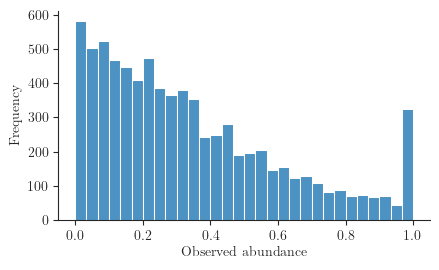

In [67]:
fig = plt.figure(figsize=(4.5, 2.8))
sns.histplot(y_true, bins=30, alpha=0.8)
sns.despine()
plt.ylabel("Frequency")
plt.xlabel("Observed abundance")
plt.tight_layout()
fig.savefig("../../figures/observed_data_untransformed.pdf")
plt.show()

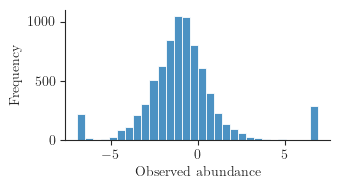

In [75]:
fig = plt.figure(figsize=(3.5, 2))
sns.histplot(y_true, bins=30, alpha=0.8)
sns.despine()
plt.ylabel("Frequency")
plt.xlabel("Observed abundance")
plt.tight_layout()
fig.savefig("../../figures/observed_data_logit.pdf")
plt.show()

## Calibration plots

Predictions and observed are not back-transformed, posterior mean of predictions are used

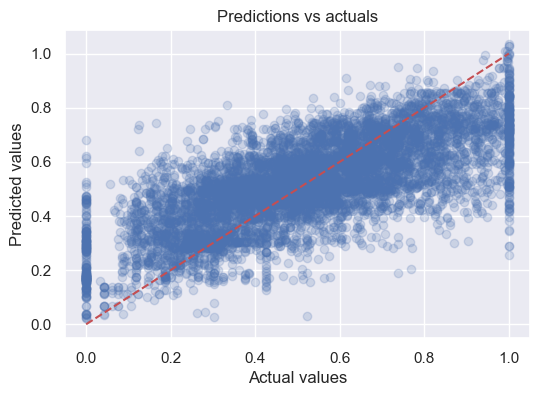

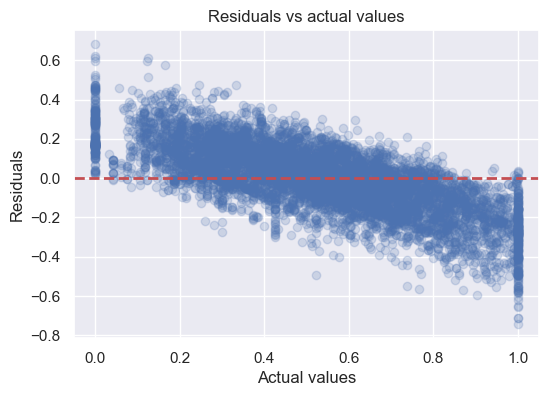

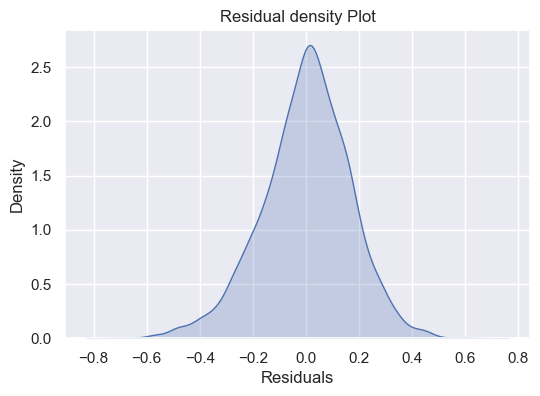

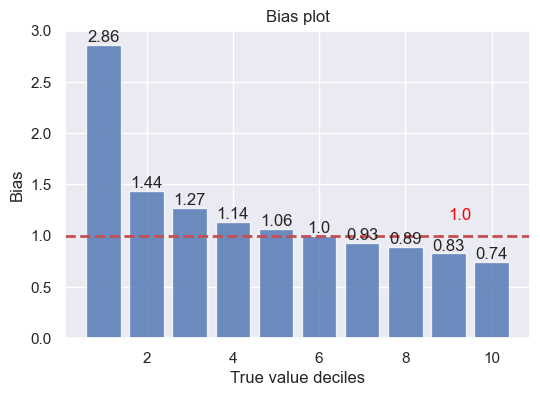

In [25]:
plot_calibration_and_residuals(y_true, y_pred_mean)

### Group level plots

### Calibration

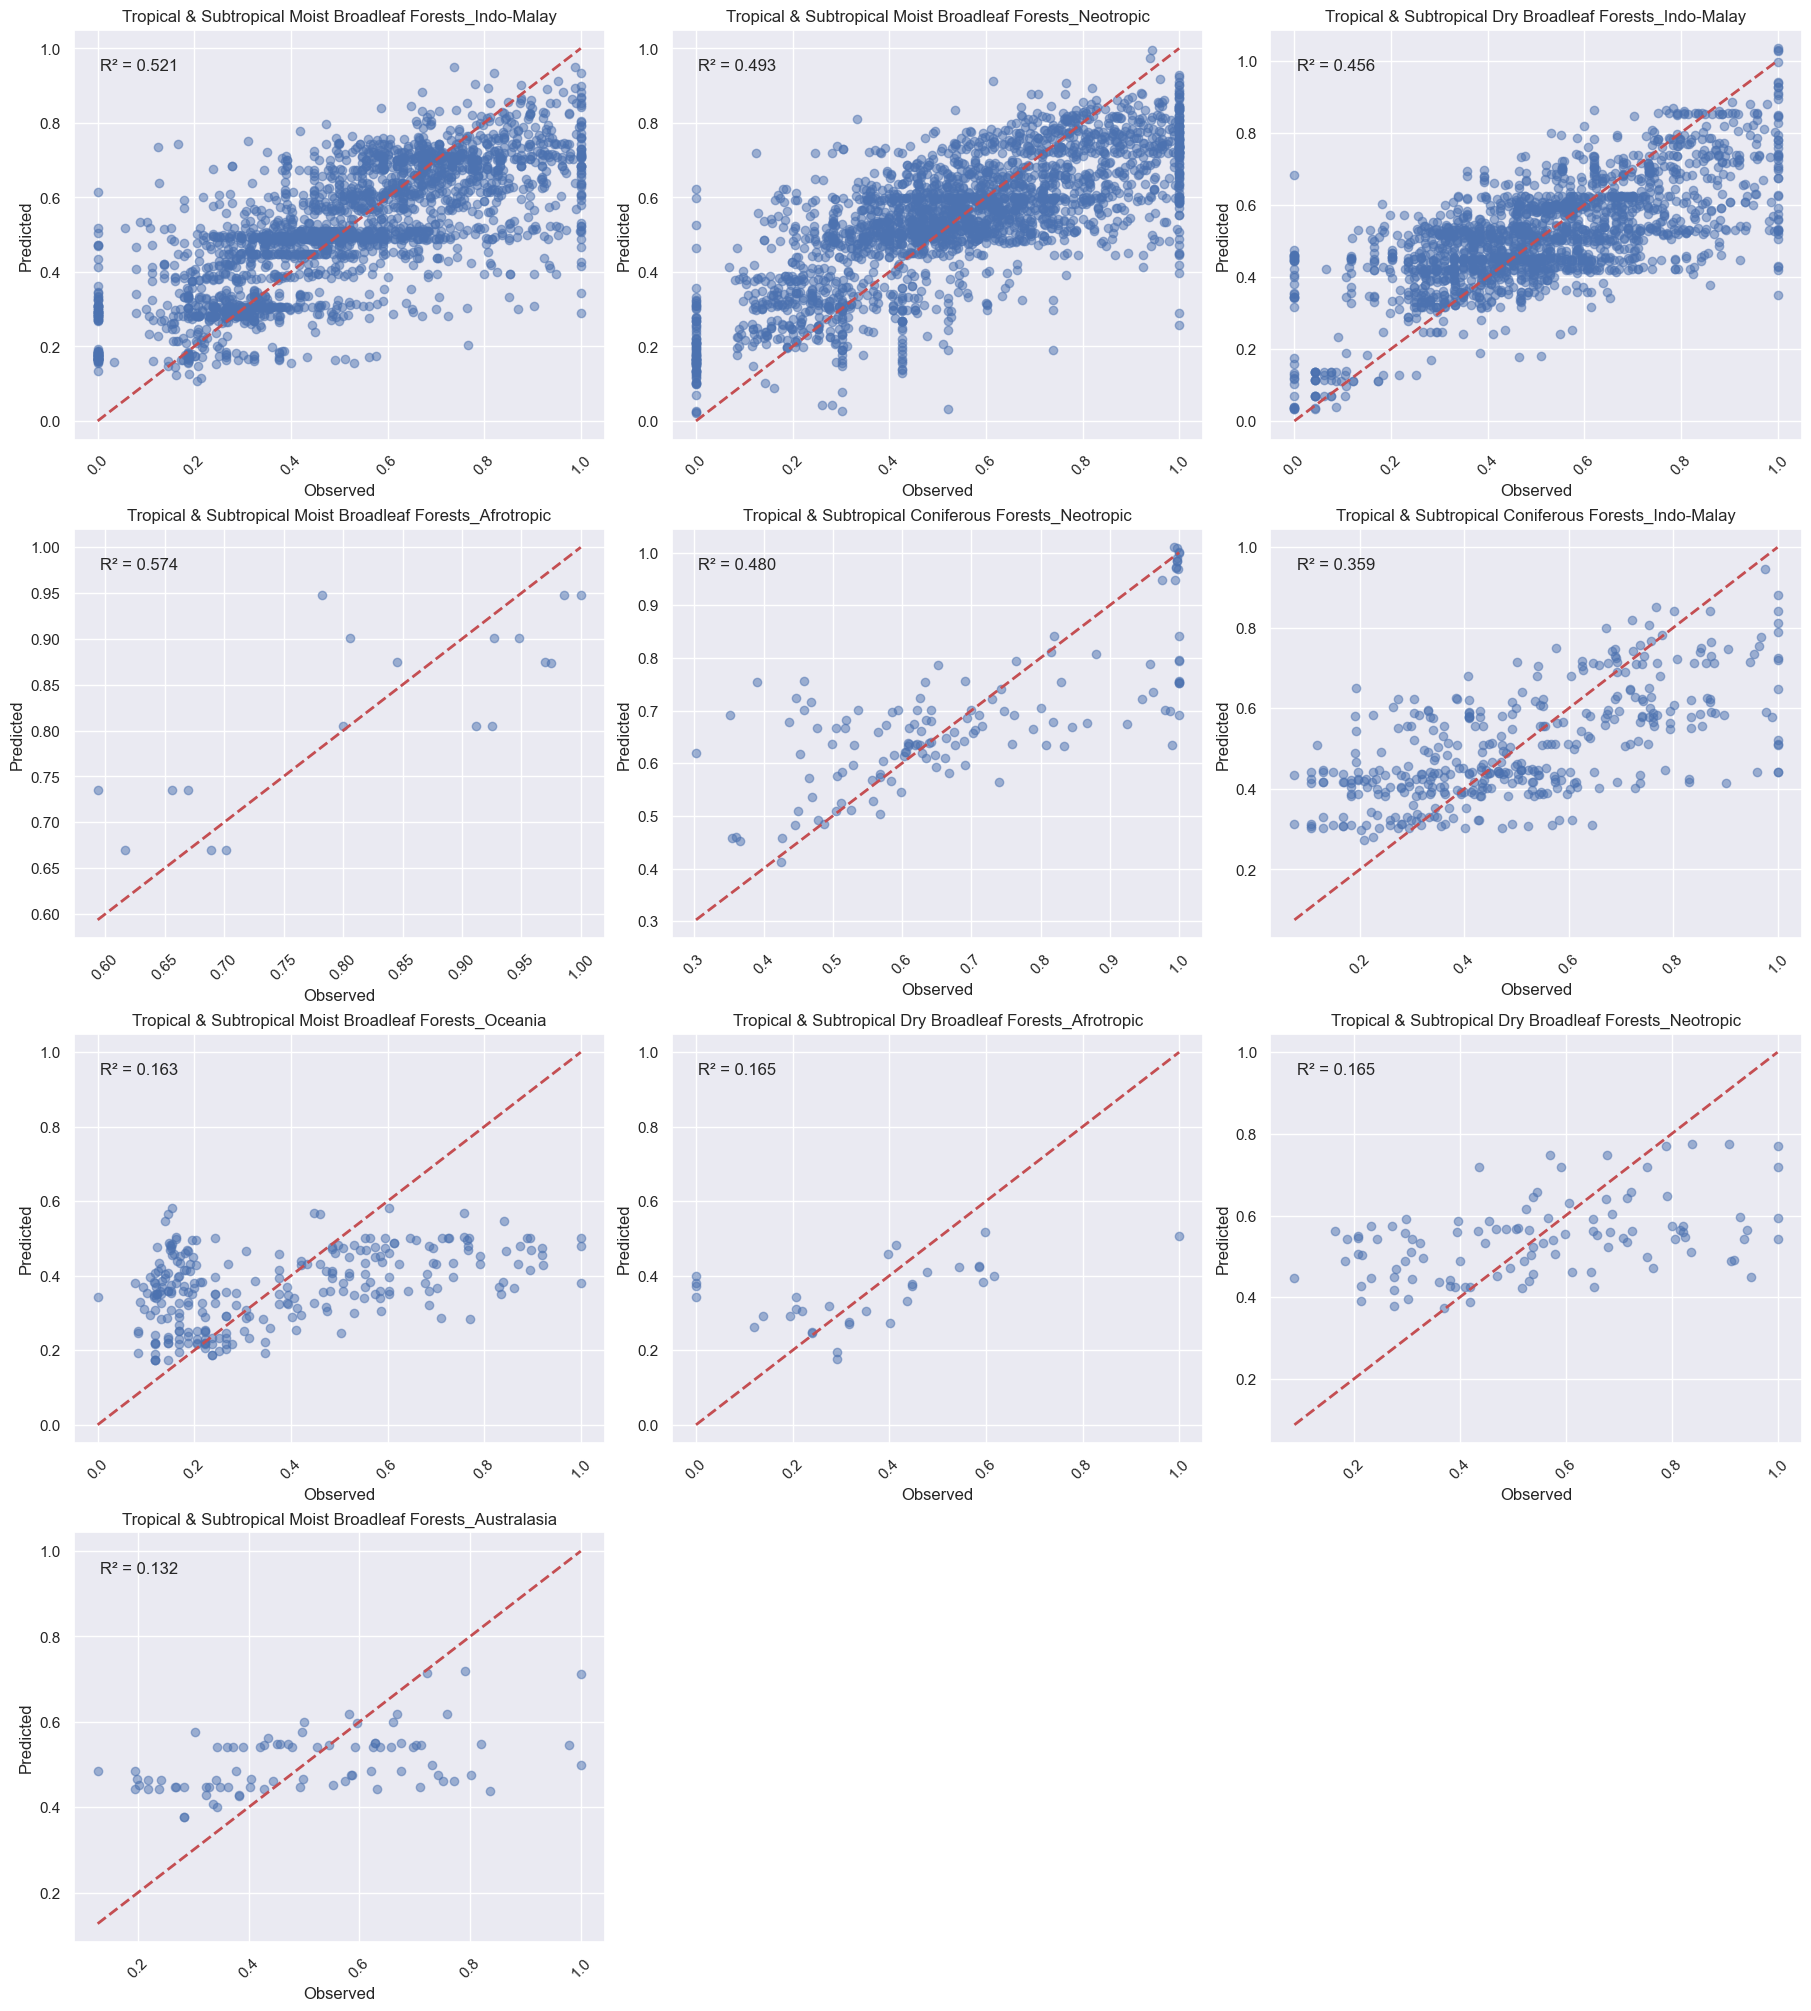

In [26]:
plot_calibration_by_group(
    y_true,
    y_pred_mean,
    group_idx=model_data["biome_realm_idx"],
    group_mapping=realm_mapping,
)

### Residuals

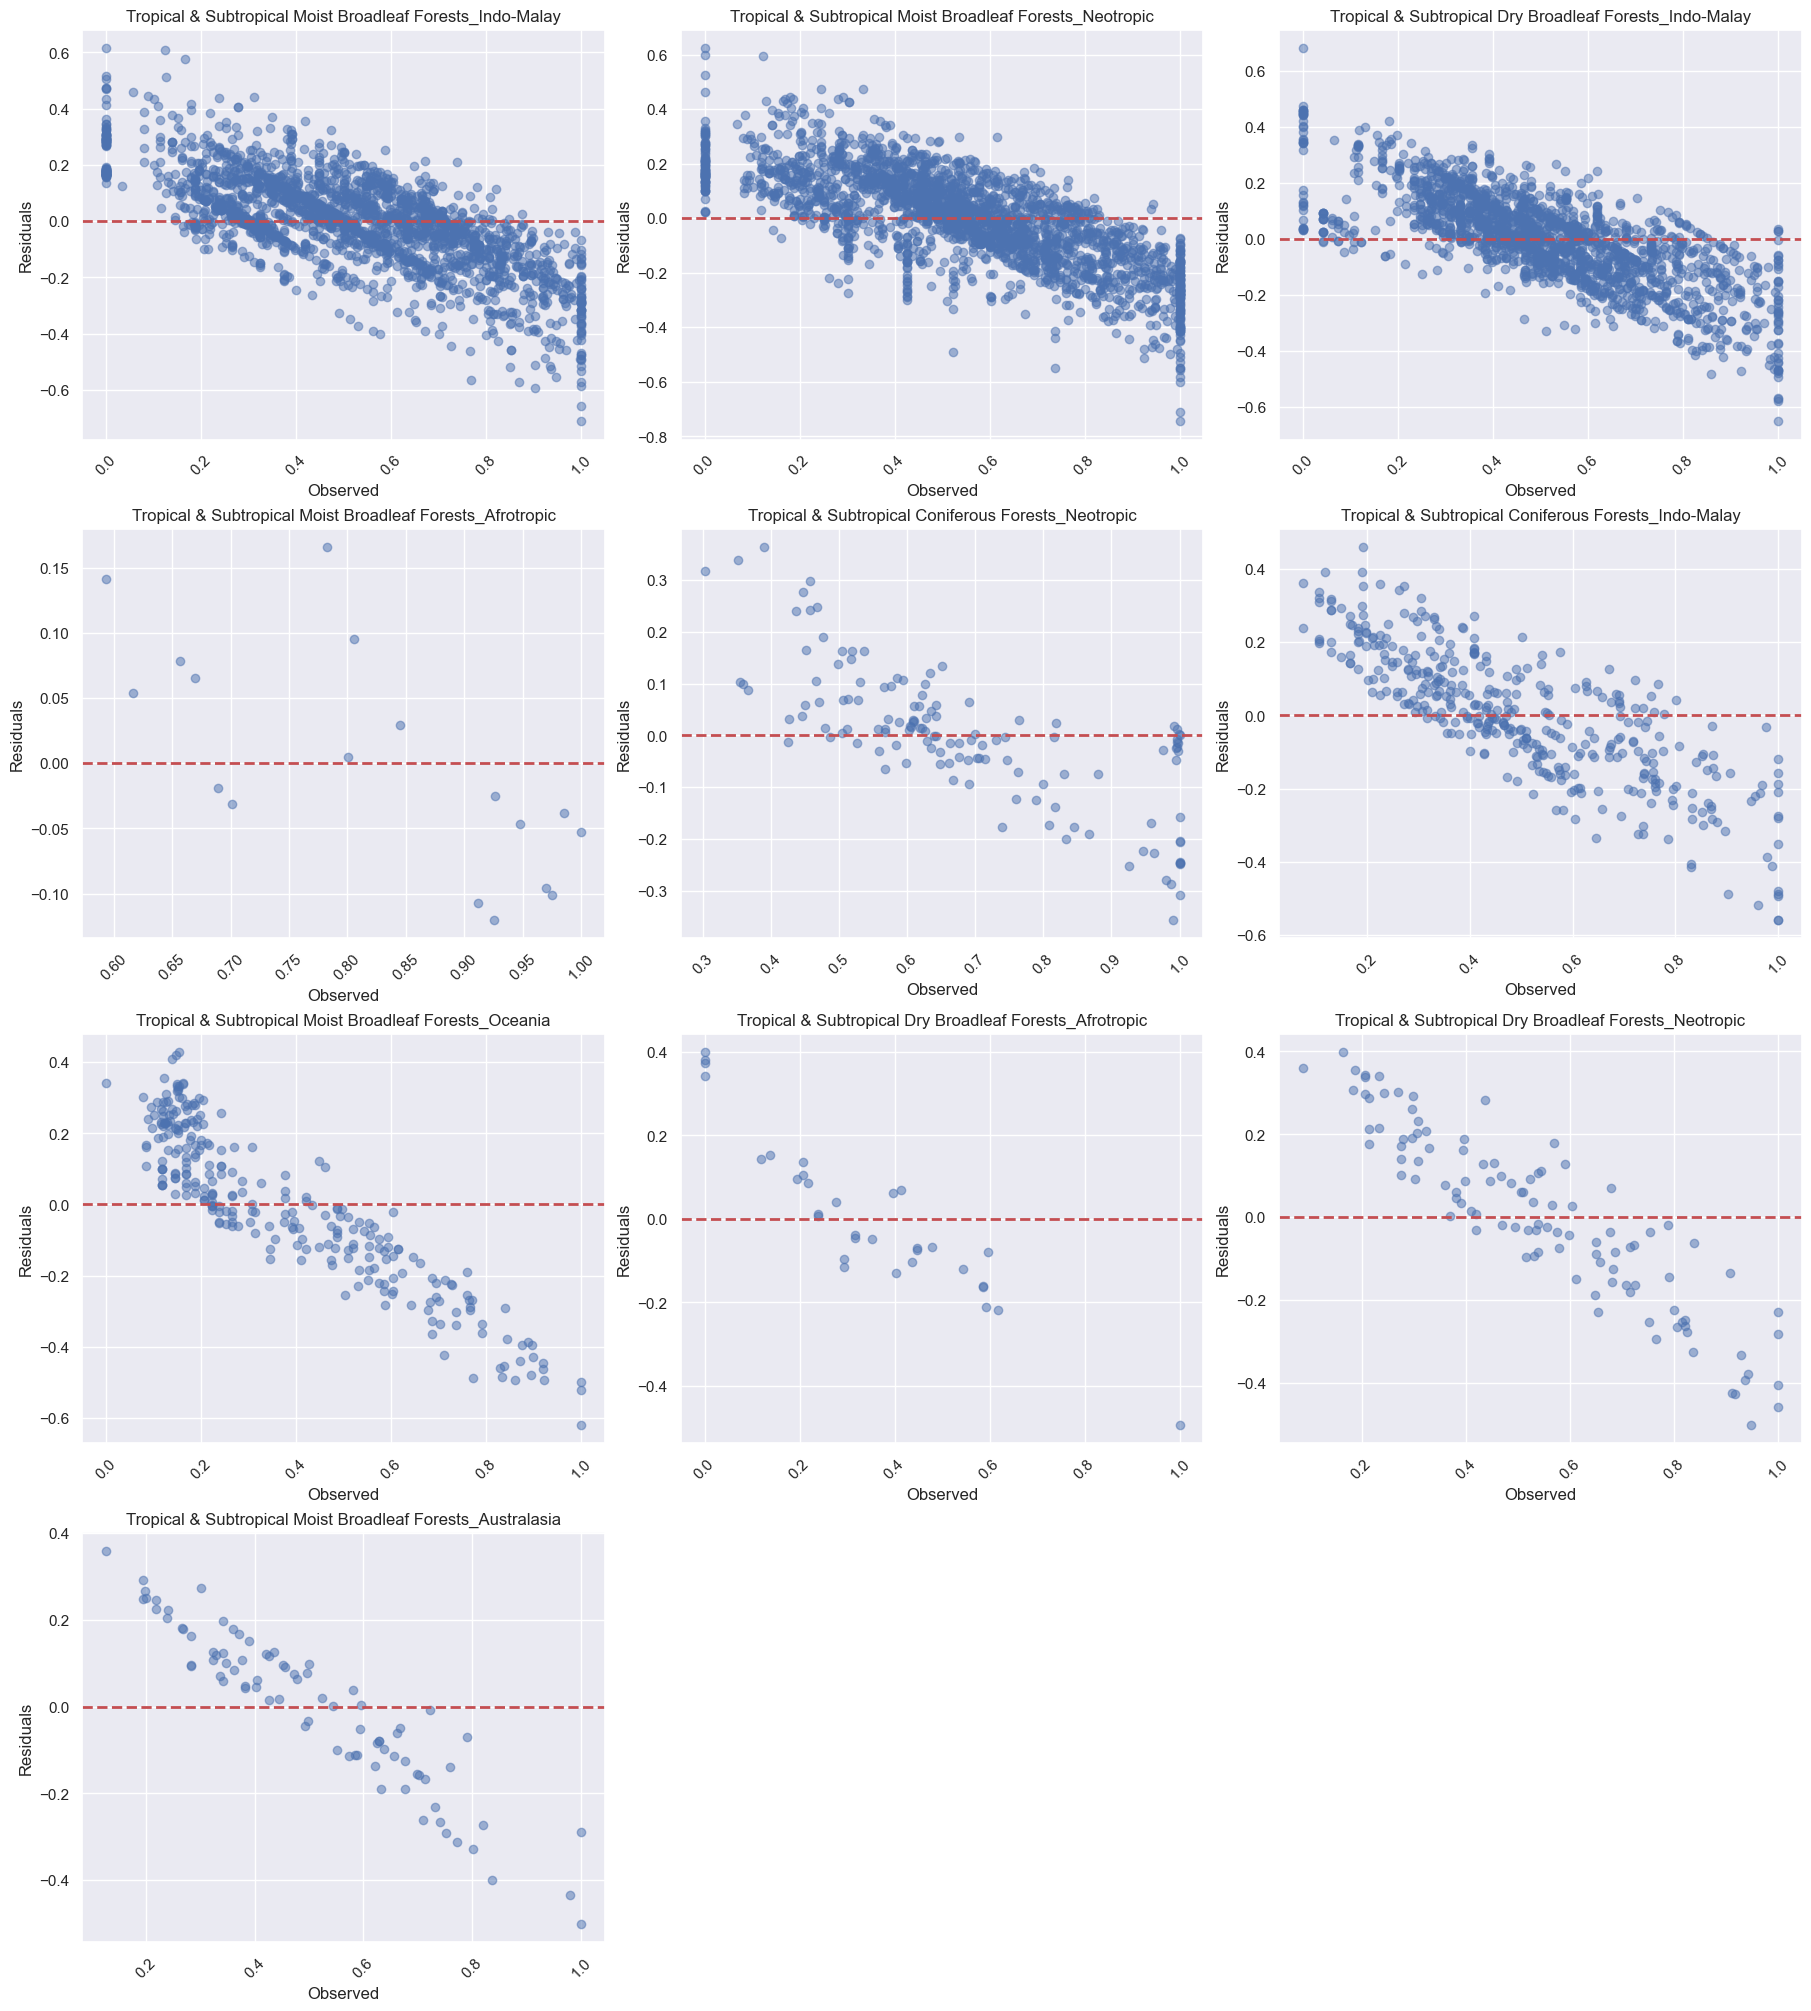

In [27]:
plot_residuals_by_group(
    y_true,
    y_pred_mean,
    group_idx=model_data["biome_realm_idx"],
    group_mapping=realm_mapping,
)

## Explained variance (R2 scores)

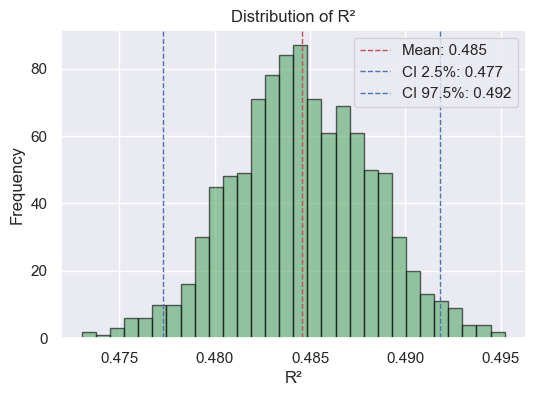

In [28]:
r2_scores = calculate_bayesian_r2(y_true, y_pred)
plot_performance_distribution(r2_scores, metric="R²")

## Predictive performance (in-sample)

In [29]:
mean_abs_err = []
median_abs_err = []
for s in range(y_pred_trans.shape[0]):
    mean = mean_absolute_error(y_true_trans, y_pred_trans[s])
    mean_abs_err.append(mean)
    median = median_absolute_error(y_true_trans, y_pred_trans[s])
    median_abs_err.append(median)

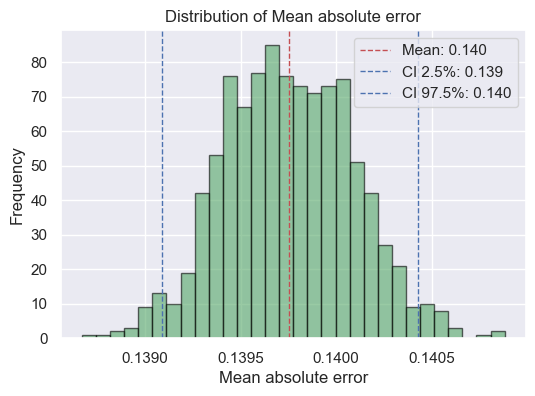

In [30]:
plot_performance_distribution(mean_abs_err, "Mean absolute error")

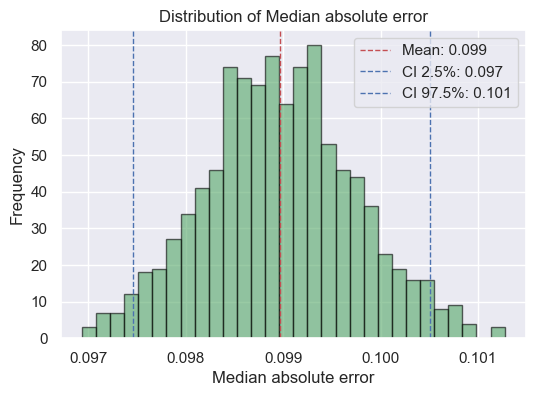

In [31]:
plot_performance_distribution(median_abs_err, "Median absolute error")

### Top / bottom quartile performance

In [49]:
q1 = np.percentile(y_true_trans, 25)
q3 = np.percentile(y_true_trans, 75)
bottom_indices = np.where(y_true_trans <= q1)[0]
top_indices = np.where(y_true_trans >= q3)[0]

bottom_quartile_true = y_true_trans[bottom_indices]
top_quartile_true = y_true_trans[top_indices]
bottom_quartile_pred = y_pred_mean_trans[bottom_indices]
top_quartile_pred = y_pred_mean_trans[top_indices]

mean_top = mean_absolute_error(top_quartile_true, top_quartile_pred)
mean_bottom = mean_absolute_error(bottom_quartile_true, bottom_quartile_pred)
median_top = median_absolute_error(top_quartile_true, top_quartile_pred)
median_bottom = median_absolute_error(bottom_quartile_true, bottom_quartile_pred)

print(f"Mean absolute error, top quartile: {mean_top:.3f}")
print(f"Mean absolute error, bottom quartile: {mean_bottom:.3f}")
print("\n")
print(f"Median absolute error, top quartile: {median_top:.3f}")
print(f"Median absolute error, bottom quartile: {median_bottom:.3f}")

Mean absolute error, top quartile: 0.266
Mean absolute error, bottom quartile: 0.095


Median absolute error, top quartile: 0.238
Median absolute error, bottom quartile: 0.077


## Pseudo cross-validation (PSIS-LOO-CV) and WAIC

In [1078]:
waic = az.waic(original_trace, var_name="y_like")
waic

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 7732 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1021.87    81.76
p_waic      498.00        -

There has been a warning during the calculation. Please check the results.

In [1079]:
loo = az.loo(original_trace, var_name="y_like")
loo

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 7732 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   996.01    82.18
p_loo      523.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     7566   97.9%
 (0.5, 0.7]   (ok)        118    1.5%
   (0.7, 1]   (bad)        47    0.6%
   (1, Inf)   (very bad)    1    0.0%

## Quick calibration experiment

In [1299]:
# Set the response variable as the residuals (not inverse transformed)
y = y_true - y_pred_mean
x = np.column_stack((np.sqrt(y_true), y_true, np.square(y_true)))
# x = y_true.reshape(-1, 1)

In [1300]:
lr = LinearRegression()
lr.fit(x, y)
res_correction = lr.predict(x)

In [1297]:
lr.coef_

array([0.13454413, 0.12044325, 0.27317473])

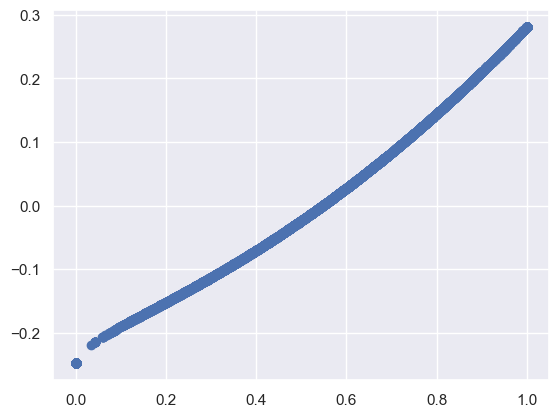

In [1301]:
plt.scatter(y_true, res_correction);

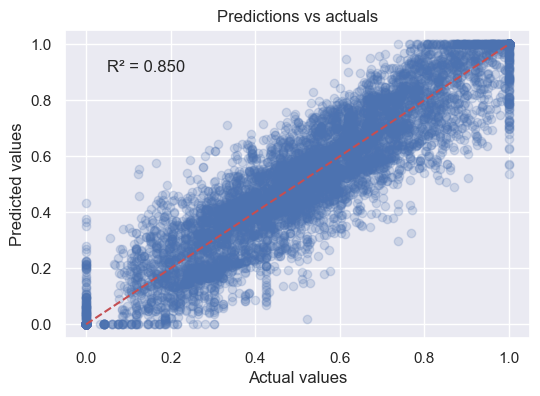

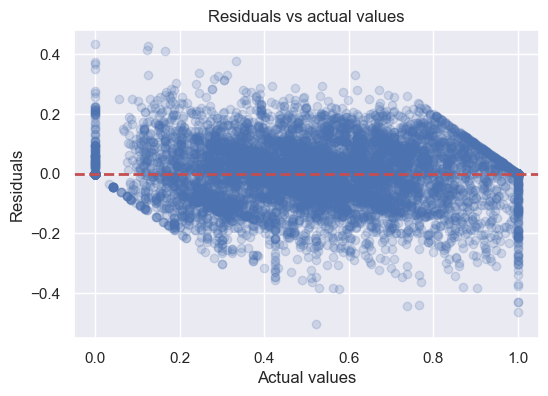

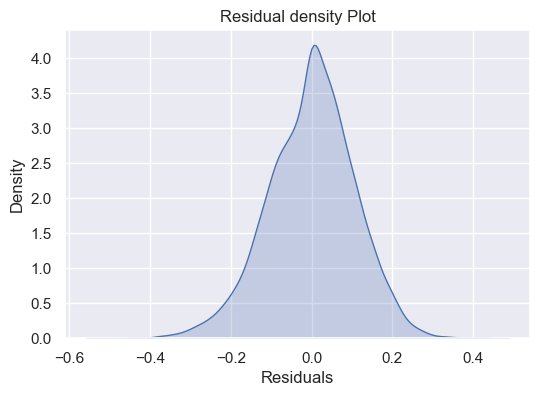

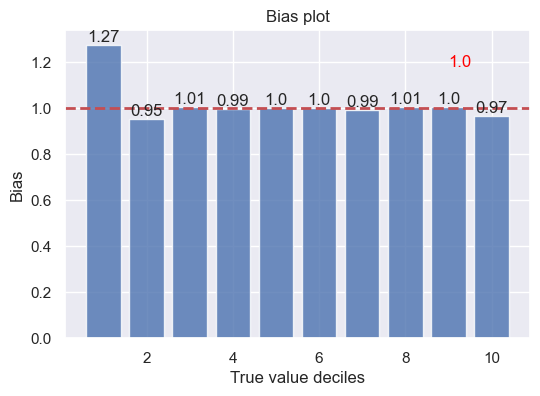

In [1304]:
# Apply the calibration correction
y_pred_new = y_pred_mean + res_correction
y_pred_new = np.where(y_pred_new < 0, 0, y_pred_new)
y_pred_new = np.where(y_pred_new > 1, 1, y_pred_new)

plot_calibration_and_residuals(y_true, y_pred_new)

In [1305]:
# Inverse transform the new predictions
y_pred_new_trans = inverse_transform_response(y_pred_new, transform)

mean_abs_err = mean_absolute_error(y_true_trans, y_pred_new_trans)
median_abs_err = median_absolute_error(y_true_trans, y_pred_new_trans)
print(f"Mean absolute error: {mean_abs_err:.3f}")
print(f"Median absolute error: {median_abs_err:.3f}")

Mean absolute error: 0.087
Median absolute error: 0.061


In [1306]:
bottom_quartile_pred = y_pred_new_trans[bottom_indices]
top_quartile_pred = y_pred_new_trans[top_indices]

mean_top = mean_absolute_error(top_quartile_true, top_quartile_pred)
mean_bottom = mean_absolute_error(bottom_quartile_true, bottom_quartile_pred)
median_top = median_absolute_error(top_quartile_true, top_quartile_pred)
median_bottom = median_absolute_error(bottom_quartile_true, bottom_quartile_pred)

print(f"Mean absolute error, top quartile: {mean_top:.3f}")
print(f"Mean absolute error, bottom quartile: {mean_bottom:.3f}")
print(f"Median absolute error, top quartile: {median_top:.3f}")
print(f"Median absolute error, bottom quartile: {median_bottom:.3f}")

Mean absolute error, top quartile: 0.138
Mean absolute error, bottom quartile: 0.041
Median absolute error, top quartile: 0.118
Median absolute error, bottom quartile: 0.033


## Posterior predictive distribution

Sampling: [y_like]
INFO:pymc.sampling.forward:Sampling: [y_like]


Output()

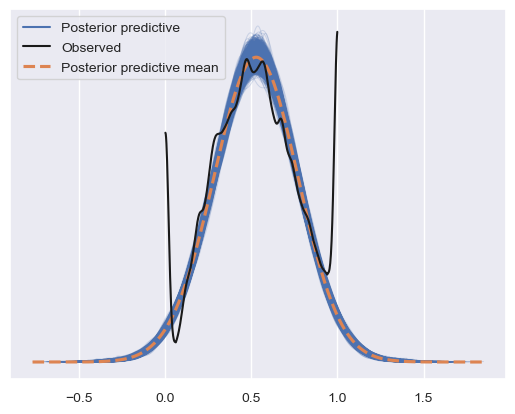

In [1307]:
with fitting_model:
    original_trace.extend(pm.sample_posterior_predictive(original_trace))

ax = az.plot_ppc(original_trace)
for label in ax.get_xticklabels():
    label.set_fontsize(10)
plt.xlabel("")
ax.legend(fontsize=10)
plt.show()

## Cross-validation results and analysis

In [ ]:
# Relevant model runs:

# Detailed LUI covariates, sqrt: run_folder_2024-05-10_22.46
# Simplified LUI covariates, sqrt: run_folder_2024-05-10_14.48
# Detailed LUI, run with additional output: run_folder_2024-05-20_10.38
# run_folder_2024-05-16_19.46

In [119]:
# Load the model output dictionary and extract all variables
output_path = "../../data/runs/run_folder_2024-05-20_10.38/cv_output.pkl"

with open(output_path, "rb") as in_stream:
    cv_output = dill.load(in_stream)

train_pred = cv_output["train_predictions"]
train_obs = cv_output["train_observed"]
test_pred = cv_output["test_predictions"]
test_obs = cv_output["test_observed"]
traces = cv_output["traces"]
site_name_to_idx = cv_output["site_name_to_idx"]

In [120]:
traces[0]

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [96]:
transform = "sqrt"

mean_abs_err_train = []
mean_abs_err_test = []
median_abs_err_train = []
median_abs_err_test = []

for k in range(len(train_pred)):
    train_pred_k = inverse_transform_response(np.mean(train_pred[k], axis=0), transform)
    train_obs_k = inverse_transform_response(train_obs[k], transform)
    mean = mean_absolute_error(train_obs_k, train_pred_k)
    median = median_absolute_error(train_obs_k, train_pred_k)
    mean_abs_err_train.append(mean)
    median_abs_err_train.append(median)

    test_pred_k = inverse_transform_response(np.mean(test_pred[k], axis=0), transform)
    test_obs_k = inverse_transform_response(test_obs[k], transform)
    mean = mean_absolute_error(test_obs_k, test_pred_k)
    median = median_absolute_error(test_obs_k, test_pred_k)
    mean_abs_err_test.append(mean)
    median_abs_err_test.append(median)

In [122]:
47 * 84

3948

In [87]:
print(
    f"Mean abs error, test: {np.mean(mean_abs_err_test):.3f} (mean) | {np.std(mean_abs_err_test):.3f} (std)"
)
print(
    f"Mean abs error, train: {np.mean(mean_abs_err_train):.3f} (mean) | {np.std(mean_abs_err_train):.3f} (std)"
)
print(
    f"Median abs error, test: {np.mean(median_abs_err_test):.3f} (mean) | {np.std(median_abs_err_test):.3f} (std)"
)
print(
    f"Median abs error, train: {np.mean(median_abs_err_train):.3f} (mean) | {np.std(median_abs_err_train):.3f} (std)"
)

Mean abs error, test: 0.177 (mean) | 0.019 (std)
Mean abs error, train: 0.146 (mean) | 0.001 (std)
Median abs error, test: 0.132 (mean) | 0.018 (std)
Median abs error, train: 0.105 (mean) | 0.001 (std)


### Top / bottom quartile

In [81]:
# On test data
mean_top_res = []
mean_bottom_res = []
median_top_res = []
median_bottom_res = []

for k in range(len(train_pred)):
    test_pred_k = inverse_transform_response(np.mean(test_pred[k], axis=0), transform)
    test_obs_k = inverse_transform_response(test_obs[k], transform)

    q1 = np.percentile(test_obs_k, 25)
    q3 = np.percentile(test_obs_k, 75)
    bottom_indices = np.where(test_obs_k <= q1)[0]
    top_indices = np.where(test_obs_k >= q3)[0]

    bottom_quartile_true = test_obs_k[bottom_indices]
    top_quartile_true = test_obs_k[top_indices]
    bottom_quartile_pred = test_pred_k[bottom_indices]
    top_quartile_pred = test_pred_k[top_indices]

    mean_top = mean_absolute_error(top_quartile_true, top_quartile_pred)
    mean_top_res.append(mean_top)
    mean_bottom = mean_absolute_error(bottom_quartile_true, bottom_quartile_pred)
    mean_bottom_res.append(mean_bottom)
    median_top = median_absolute_error(top_quartile_true, top_quartile_pred)
    median_top_res.append(median_top)
    median_bottom = median_absolute_error(bottom_quartile_true, bottom_quartile_pred)
    median_bottom_res.append(median_bottom)

print(f"Mean absolute error, top quartile: {np.mean(mean_top_res):.3f}")
print(f"Mean absolute error, bottom quartile: {np.mean(mean_bottom):.3f}")
print("\n")
print(f"Median absolute error, top quartile: {np.mean(median_top):.3f}")
print(f"Median absolute error, bottom quartile: {np.mean(median_bottom):.3f}")

Mean absolute error, top quartile: 0.300
Mean absolute error, bottom quartile: 0.103


Median absolute error, top quartile: 0.274
Median absolute error, bottom quartile: 0.082


## Out-of-sample calibration

In [97]:
# Plot of predictions and actuals before calibration
all_pred = []
all_obs = []
for k in range(len(train_pred)):
    test_pred_k = inverse_transform_response(np.mean(test_pred[k], axis=0), transform)
    all_pred.append(test_pred_k)
    test_obs_k = inverse_transform_response(test_obs[k], transform)
    all_obs.append(test_obs_k)

pred_test = np.concatenate(all_pred).ravel()
pred_test = np.where(pred_test > 1, 1, pred_test)
obs_test = np.concatenate(all_obs).ravel()

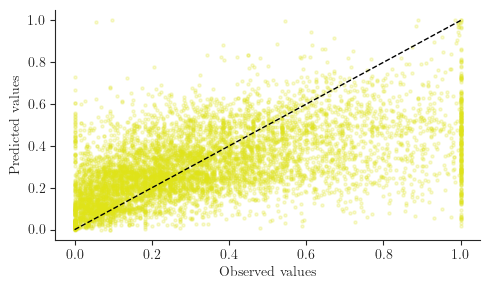

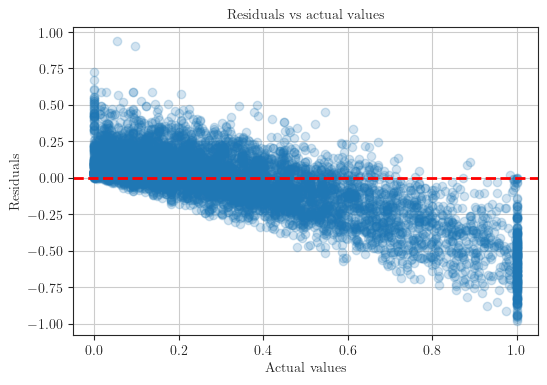

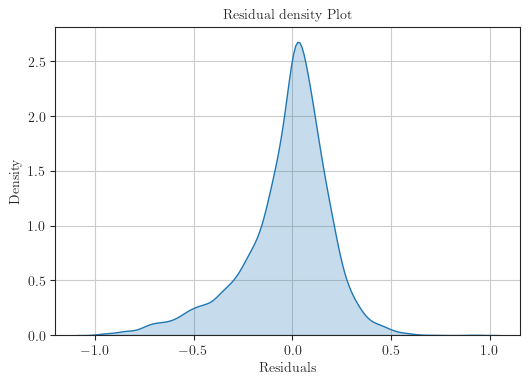

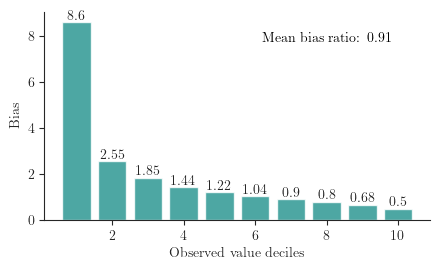

In [116]:
fig = plot_calibration_and_residuals(obs_test, pred_test)
fig.savefig("../../figures/detailed_lui_model_bias.pdf")

In [106]:
calibrated_test_pred = []
all_y_test = []

for k in range(len(train_pred)):
    train_pred_k = inverse_transform_response(np.mean(train_pred[k], axis=0), transform)
    train_obs_k = inverse_transform_response(train_obs[k], transform)
    test_pred_k = inverse_transform_response(np.mean(test_pred[k], axis=0), transform)
    test_obs_k = inverse_transform_response(test_obs[k], transform)

    y_train = train_obs_k - train_pred_k
    x_train = np.column_stack(
        (np.sqrt(train_obs_k), train_obs_k, np.square(train_obs_k))
    )
    x_test = np.column_stack((np.sqrt(test_obs_k), test_obs_k, np.square(test_obs_k)))

    lr = LinearRegression()
    lr.fit(x_train, y_train)
    res_correction = lr.predict(x_test)

    test_pred_new = test_pred_k + res_correction
    test_pred_new = np.where(test_pred_new < 0, 0, test_pred_new)
    test_pred_new = np.where(test_pred_new > 1, 1, test_pred_new)
    calibrated_test_pred.append(test_pred_new)
    all_y_test.append(test_obs_k)

calibrated_test_pred = np.concatenate(calibrated_test_pred).ravel()
all_y_test = np.concatenate(all_y_test).ravel()

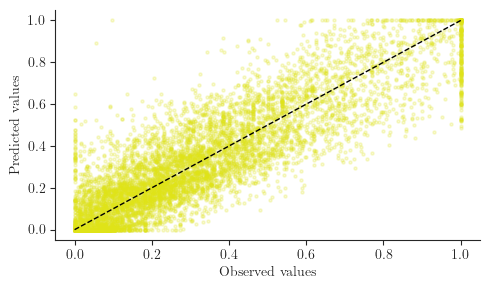

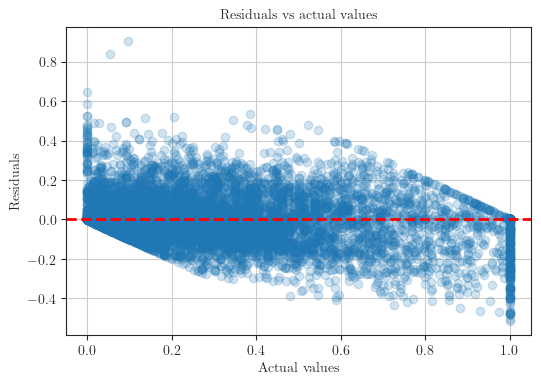

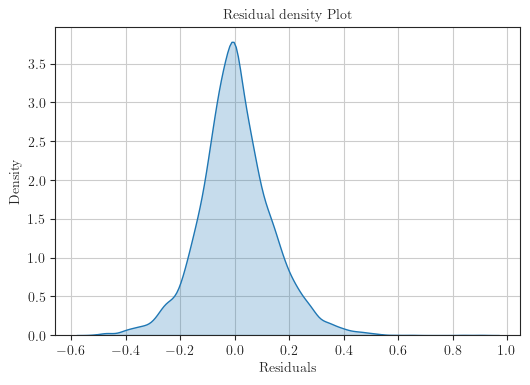

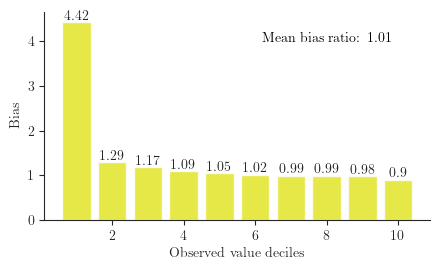

In [114]:
fig = plot_calibration_and_residuals(all_y_test, calibrated_test_pred)
fig.savefig("../../figures/calibrated_bias.pdf")

In [1387]:
mean_abs_err = mean_absolute_error(all_y_test, calibrated_test_pred)
median_abs_err = median_absolute_error(all_y_test, calibrated_test_pred)
print(f"Mean absolute error: {mean_abs_err:.3f}")
print(f"Median absolute error: {median_abs_err:.3f}")

Mean absolute error: 0.100
Median absolute error: 0.076


In [1388]:
q1 = np.percentile(all_y_test, 25)
q3 = np.percentile(all_y_test, 75)
bottom_indices = np.where(all_y_test <= q1)[0]
top_indices = np.where(all_y_test >= q3)[0]

bottom_quartile_true = all_y_test[bottom_indices]
top_quartile_true = all_y_test[top_indices]
bottom_quartile_pred = calibrated_test_pred[bottom_indices]
top_quartile_pred = calibrated_test_pred[top_indices]

mean_top = mean_absolute_error(top_quartile_true, top_quartile_pred)
mean_bottom = mean_absolute_error(bottom_quartile_true, bottom_quartile_pred)
median_top = median_absolute_error(top_quartile_true, top_quartile_pred)
median_bottom = median_absolute_error(bottom_quartile_true, bottom_quartile_pred)

print(f"Mean absolute error, top quartile: {mean_top:.3f}")
print(f"Mean absolute error, bottom quartile: {mean_bottom:.3f}")
print(f"Median absolute error, top quartile: {median_top:.3f}")
print(f"Median absolute error, bottom quartile: {median_bottom:.3f}")

Mean absolute error, top quartile: 0.128
Mean absolute error, bottom quartile: 0.078
Median absolute error, top quartile: 0.112
Median absolute error, bottom quartile: 0.055


### Train calibration

In [1390]:
calibrated_train_pred = []
all_y_train = []

for k in range(len(train_pred)):
    train_pred_k = inverse_transform_response(np.mean(train_pred[k], axis=0), transform)
    train_obs_k = inverse_transform_response(train_obs[k], transform)

    y_train = train_obs_k - train_pred_k
    x_train = np.column_stack(
        (np.sqrt(train_obs_k), train_obs_k, np.square(train_obs_k))
    )

    lr = LinearRegression()
    lr.fit(x_train, y_train)
    res_correction = lr.predict(x_train)

    train_pred_new = train_pred_k + res_correction
    train_pred_new = np.where(train_pred_new < 0, 0, train_pred_new)
    train_pred_new = np.where(train_pred_new > 1, 1, train_pred_new)
    calibrated_train_pred.append(train_pred_new)
    all_y_train.append(train_obs_k)

calibrated_train_pred = np.concatenate(calibrated_train_pred).ravel()
all_y_train = np.concatenate(all_y_train).ravel()

In [1391]:
mean_abs_err = mean_absolute_error(all_y_train, calibrated_train_pred)
median_abs_err = median_absolute_error(all_y_train, calibrated_train_pred)
print(f"Mean absolute error: {mean_abs_err:.3f}")
print(f"Median absolute error: {median_abs_err:.3f}")

Mean absolute error: 0.084
Median absolute error: 0.066


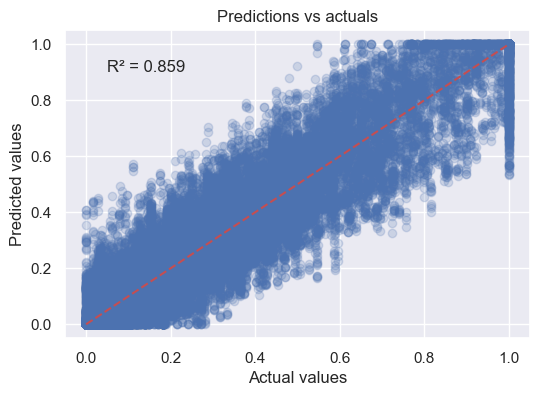

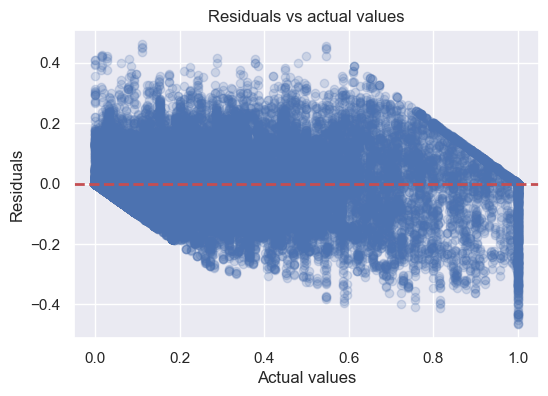

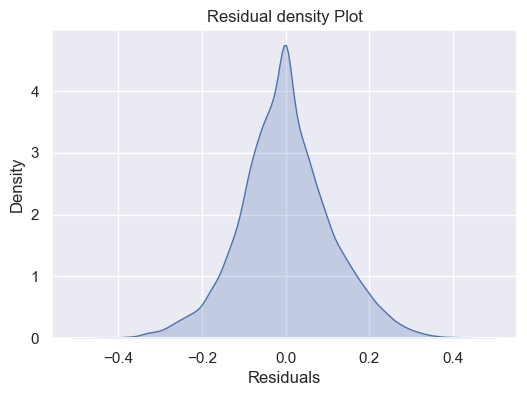

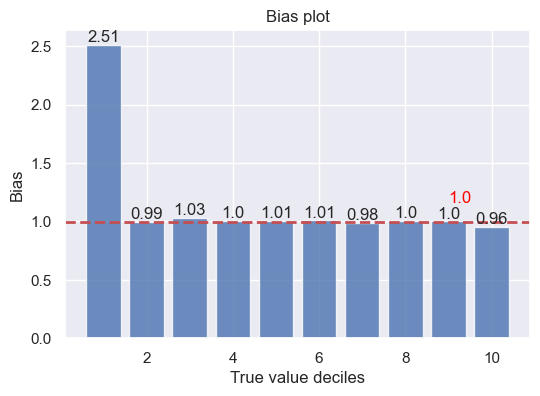

In [1413]:
plot_calibration_and_residuals(all_y_train, calibrated_train_pred)

## Final outputs including scaling

In [201]:
idx_to_site_name = {val: key for key, val in site_name_to_idx.items()}
df_output = pd.DataFrame()

for i, trace in enumerate(traces):
    df_test = pd.DataFrame()

    # Get site indices and fetch site names
    df_test["SSBS_idx"] = trace.predictions_constant_data["site_idx"].values
    df_test["SSBS"] = df_test["SSBS_idx"].map(idx_to_site_name)

    # Get observed values
    observed = inverse_transform_response(
        trace.predictions_constant_data["y_obs"].values, "sqrt"
    )
    df_test["Observed"] = observed

    # Get the predictions
    pred = inverse_transform_response(
        trace.predictions["y_like"].mean(dim=["chain", "draw"]).values, "sqrt"
    )

    # Get reference predictions
    alpha_eco = inverse_transform_response(
        trace.predictions["alpha_eco_site"].mean(dim=["chain", "draw"]).values, "sqrt"
    )
    ref_pred_eco = inverse_transform_response(
        trace.predictions["ref_pred_eco"].mean(dim=["chain", "draw"]).values, "sqrt"
    )
    alpha_realm = inverse_transform_response(
        trace.predictions["alpha_realm_site"].mean(dim=["chain", "draw"]).values, "sqrt"
    )
    ref_pred_realm = inverse_transform_response(
        trace.predictions["ref_pred_realm"].mean(dim=["chain", "draw"]).values, "sqrt"
    )

    df_test["Pred"] = pred
    df_test["Ref_pred_eco"] = ref_pred_eco
    df_test["Ref_pred_realm"] = ref_pred_realm
    df_test["Alpha_eco_site"] = alpha_eco
    df_test["Alpha_realm_site"] = alpha_realm

    df_test["Final_output_eco_1"] = df_test["Pred"] / df_test["Ref_pred_eco"]
    df_test["Final_output_eco_2"] = df_test["Pred"] / df_test["Alpha_eco_site"]
    df_test["Final_output_realm_1"] = df_test["Pred"] / df_test["Ref_pred_realm"]
    df_test["Final_output_realm_2"] = df_test["Pred"] / df_test["Alpha_realm_site"]

    df_output = pd.concat([df_output, df_test], ignore_index=True).sort_values("SSBS")

In [202]:
df_output.head(20)

SSBS_idx                     SSBS  Observed      Pred  Ref_pred_eco  \
6073      3520      AD1_2001__Liow 3  1  0.379657  0.481009      0.568278   
0         6946      AD1_2001__Liow 3  2  0.831756  0.586922      0.523365   
6074      5353  AD1_2002__Tonhasca 1  1  0.430810  0.564326      0.520739   
1         5134  AD1_2002__Tonhasca 1  2  0.474571  0.446719      0.514948   
2         6116  AD1_2002__Tonhasca 1  3  0.491721  0.442590      0.565225   
6075      4298  AD1_2002__Tonhasca 1  4  0.950917  0.748228      0.520739   
6076       381  AD1_2002__Tonhasca 1  5  0.714666  0.749946      0.520739   
3         1095  AD1_2002__Tonhasca 1  6  0.448255  0.531030      0.478834   
6077      7018  AD1_2002__Tonhasca 1  7  0.847059  0.205598      0.178259   
4         7355  AD1_2002__Tonhasca 1  8  0.352159  0.572226      0.516041   
6078      3609  AD1_2002__Tonhasca 1  9  0.529412  0.269306      0.182117   
6079       720   AD1_2009__Vergara 1  1  0.329412  0.235169      0.138571   
5          916  AD1_2009__Vergara 1  10  1.000000  0.856794      0.547932   
6         5274  AD1_2009__Vergara 1  11  0.649616  0.860196      0.514948   
7          273  AD1_2009__Vergara 1  12  0.640449  0.555399      0.487918   
8         7201  AD1_2009__Vergara 1  13  0.588235  0.205647      0.153032   
9         7496  AD1_2009__Vergara 1  14  0.858664  0.792571      0.512152   
10         383  AD1_2009__Vergara 1  15  0.541176  0.186047      0.136770   
11        7298  AD1_2009__Vergara 1  16  0.856298  0.562842      0.487918   
12        5956   AD1_2009__Vergara 1  2  0.352941  0.248515      0.183471   

      Ref_pred_realm  Alpha_eco_site  Alpha_realm_site  Final_output_eco_1  \
6073        0.371047        0.201742          0.201288            0.846432   
0           0.242127        0.244876          0.242022            1.121439   
6074        0.420256        0.201742          0.201288            1.083702   
1           0.327628        0.244876          0.242022            0.867504   
2           0.360579        0.250350          0.245901            0.783033   
6075        0.420256        0.201742          0.201288            1.436860   
6076        0.420256        0.201742          0.201288            1.440158   
3           0.360072        0.244876          0.242022            1.109007   
6077        0.242193        0.161270          0.178564            1.153369   
4           0.391706        0.250350          0.245901            1.108876   
6078        0.247865        0.161270          0.178564            1.478756   
6079        0.230680        0.161270          0.178564            1.697104   
5           0.227079        0.247227          0.245995            1.563688   
6           0.327628        0.244876          0.242022            1.670453   
7           0.250220        0.239042          0.237117            1.138304   
8           0.239612        0.202375          0.211886            1.343812   
9           0.317840        0.247227          0.245995            1.547530   
10          0.231096        0.202375          0.211886            1.360292   
11          0.250220        0.239042          0.237117            1.153559   
12          0.248381        0.202375          0.211886            1.354520   

      Final_output_eco_2  Final_output_realm_1  Final_output_realm_2  
6073            2.384278              1.296354              2.389658  
0               2.396807              2.424028              2.425074  
6074            2.797267              1.342813              2.803578  
1               1.824264              1.363494              1.845778  
2               1.767883              1.227443              1.799873  
6075            3.708841              1.780409              3.717209  
6076            3.717354              1.784496              3.725741  
3               2.168562              1.474787              2.194137  
6077            1.274865              0.848903              1.151395  
4               2.285700              1

In [203]:
df_output.to_parquet("../../data/output/model_comp/hierarchical.parquet")

## Differences in parameter estimates

In [9]:
trace = original_trace
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [14]:
alpha_eco = trace.posterior["alpha_eco"].mean(dim=["chain", "draw"]).values
alpha_eco

array([0.37338089, 0.31123834, 0.30645228, 0.33564559, 0.34879325,
       0.34791207, 0.29891962, 0.28160464, 0.26364742, 0.31553425,
       0.31041279, 0.30980522, 0.46959426, 0.40479481, 0.41360536,
       0.41021845, 0.3954258 , 0.41857902, 0.41421987, 0.42790234,
       0.45217392, 0.44564968, 0.42766561, 0.40338927, 0.41458564,
       0.48446073, 0.38670275, 0.42659669, 0.50306326, 0.53695412,
       0.53706232, 0.49062032, 0.48342827, 0.50225255, 0.5081804 ,
       0.50660398, 0.50203103, 0.50878365, 0.51564135, 0.54356353,
       0.52285914, 0.48689739, 0.57144768, 0.53915842, 0.50303952,
       0.53912106, 0.52864817, 0.53052604, 0.49818752, 0.53610649,
       0.39100498, 0.44078013, 0.38606281, 0.42222031, 0.43780763,
       0.38665004, 0.39710914, 0.45854891, 0.46969916, 0.41716515,
       0.42574458, 0.41744786, 0.42685385, 0.4291878 , 0.43241879,
       0.40392855, 0.42649597, 0.37611734, 0.39798071, 0.42477135,
       0.4666147 , 0.44433466, 0.39315898, 0.42136297, 0.40426

In [12]:
beta_eco = trace.posterior["beta_eco"].mean(dim=["chain", "draw"]).values
beta_eco.shape

(85, 46)

In [16]:
covariates = trace.posterior["x_vars"].values
covariates

array(['Primary vegetation_Light use', 'Primary vegetation_Intense use',
       'Secondary vegetation_Minimal use',
       'Secondary vegetation_Light use',
       'Secondary vegetation_Intense use', 'Cropland_Minimal use',
       'Cropland_Light use', 'Cropland_Intense use',
       'Pasture_Minimal use', 'Pasture_Light use', 'Pasture_Intense use',
       'Urban_All uses', 'Pop_density_1km_log', 'Pop_density_50km_log',
       'Road_density_1km_cbrt', 'Road_density_50km_cbrt',
       'Annual_mean_temp_1km', 'Temp_seasonality_1km',
       'Annual_precip_1km', 'Precip_seasonality_1km', 'Elevation_10km',
       'Terrain_roughness_1km',
       'Primary vegetation_Light use x Pop_density_50km_log',
       'Primary vegetation_Intense use x Pop_density_50km_log',
       'Secondary vegetation_Minimal use x Pop_density_50km_log',
       'Secondary vegetation_Light use x Pop_density_50km_log',
       'Secondary vegetation_Intense use x Pop_density_50km_log',
       'Cropland_Minimal use x Pop_den

In [23]:
param_dict = {}
param_dict["Intercept"] = alpha_eco
for i, var in enumerate(list(covariates)):
    param_dict[var] = beta_eco[:, i]

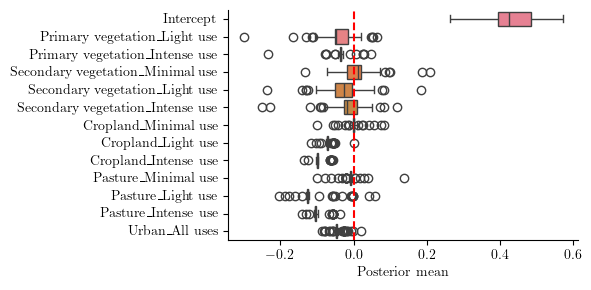

In [46]:
order = [
    "Intercept",
    "Primary vegetation_Light use",
    "Primary vegetation_Intense use",
    "Secondary vegetation_Minimal use",
    "Secondary vegetation_Light use",
    "Secondary vegetation_Intense use",
    "Cropland_Minimal use",
    "Cropland_Light use",
    "Cropland_Intense use",
    "Pasture_Minimal use",
    "Pasture_Light use",
    "Pasture_Intense use",
    "Urban_All uses",
]
filtered_dict = {
    key: val for key, val in param_dict.items() if key in param_dict.keys()
}

fig = plt.figure(figsize=(6, 3))
sns.boxplot(data=filtered_dict, order=order, orient="h")
plt.xlabel("Posterior mean")
plt.axvline(x=0, color="r", linestyle="--")
sns.despine()
plt.tight_layout()
fig.savefig("../../figures/eco_params_lui.pdf")
plt.show()

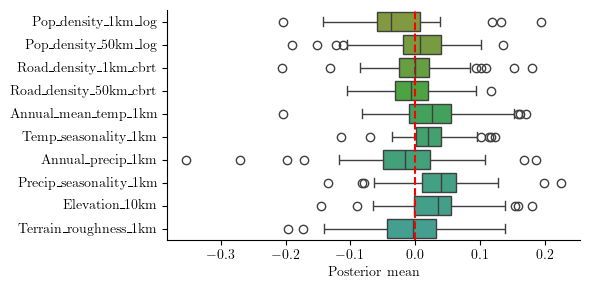

In [45]:
order = [
    "Pop_density_1km_log",
    "Pop_density_50km_log",
    "Road_density_1km_cbrt",
    "Road_density_50km_cbrt",
    "Annual_mean_temp_1km",
    "Temp_seasonality_1km",
    "Annual_precip_1km",
    "Precip_seasonality_1km",
    "Elevation_10km",
    "Terrain_roughness_1km",
]
filtered_dict = {
    key: val for key, val in param_dict.items() if key in param_dict.keys()
}

fig = plt.figure(figsize=(6, 3))
sns.boxplot(data=filtered_dict, order=order, orient="h")
plt.xlabel("Posterior mean")
plt.axvline(x=0, color="r", linestyle="--")
sns.despine()
plt.tight_layout()
fig.savefig("../../figures/eco_params_density_bio.pdf")
plt.show()

In [48]:
alpha_realm = trace.posterior["alpha_realm"].mean(dim=["chain", "draw"]).values
beta_realm = trace.posterior["beta_realm"].mean(dim=["chain", "draw"]).values
param_dict = {}
param_dict["Intercept"] = alpha_realm
for i, var in enumerate(list(covariates)):
    param_dict[var] = beta_realm[:, i]

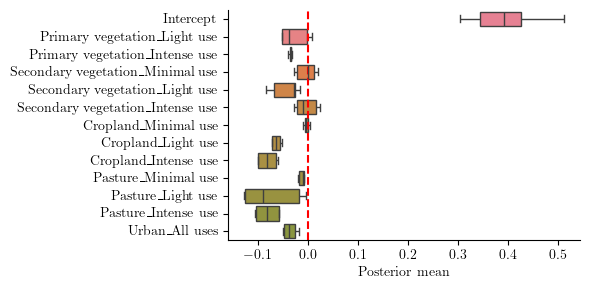

In [49]:
order = [
    "Intercept",
    "Primary vegetation_Light use",
    "Primary vegetation_Intense use",
    "Secondary vegetation_Minimal use",
    "Secondary vegetation_Light use",
    "Secondary vegetation_Intense use",
    "Cropland_Minimal use",
    "Cropland_Light use",
    "Cropland_Intense use",
    "Pasture_Minimal use",
    "Pasture_Light use",
    "Pasture_Intense use",
    "Urban_All uses",
]
filtered_dict = {
    key: val for key, val in param_dict.items() if key in param_dict.keys()
}

fig = plt.figure(figsize=(6, 3))
sns.boxplot(data=filtered_dict, order=order, orient="h")
plt.xlabel("Posterior mean")
plt.axvline(x=0, color="r", linestyle="--")
sns.despine()
plt.tight_layout()
fig.savefig("../../figures/realm_params_lui.pdf")
plt.show()

In [1444]:
# Parameter values
alpha_pop = trace.posterior["mu_a"].mean(dim=["chain", "draw"]).values.reshape(1,)
beta_pop = trace.posterior["mu_b"].mean(dim=["chain", "draw"]).values
pop = np.column_stack((alpha_pop, beta_pop))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 46

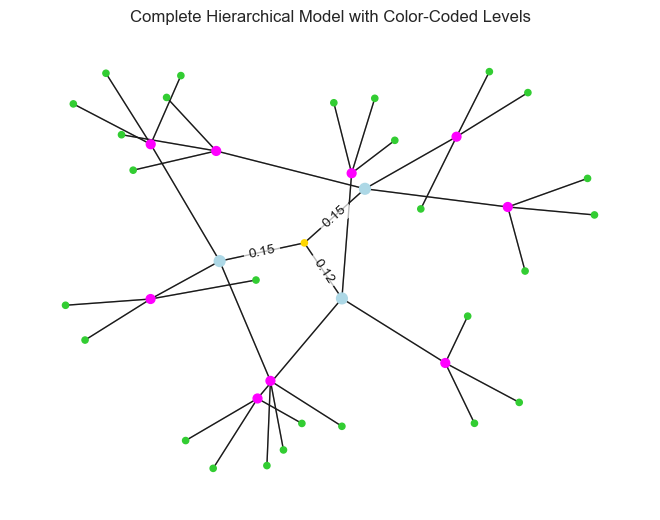

In [1430]:
# Define the hierarchical structure with vector parameters
vector_data = {
    "population": {
        "parameters": np.array(
            [0.5, 0.5, 0.5]
        ),  # Vector parameters for the population center
        "children": {},
    }
}

# Generate and populate the first, second, and third levels with vector parameters
level1_vector_params = [
    np.array([0.6, 0.4, 0.55]),
    np.array([0.4, 0.6, 0.45]),
    np.array([0.55, 0.55, 0.4]),
]
for i, parent_param in enumerate(level1_vector_params):
    group_name = f"group{i+1}"
    vector_data["population"]["children"][group_name] = {
        "parameters": parent_param,
        "size": 300,  # Base size for level 1
        "children": {},
    }
    subgroup_params = [
        np.array([x + 0.05, y - 0.05, z + 0.05])
        for x, y, z in np.tile(parent_param, (3, 1))
    ]
    for j, param in enumerate(subgroup_params):
        subgroup_name = f"subgroup{i*3+j+1}"
        vector_data["population"]["children"][group_name]["children"][subgroup_name] = {
            "parameters": param,
            "size": 200,  # Base size for level 2
            "children": {},
        }
        subsubgroup_params = [
            np.array([x + 0.05, y - 0.05, z + 0.05])
            for x, y, z in np.tile(param, (3, 1))
        ]
        for k, subparam in enumerate(subsubgroup_params):
            subsubgroup_name = f"subsubgroup{i*9+j*3+k+1}"
            vector_data["population"]["children"][group_name]["children"][
                subgroup_name
            ]["children"][subsubgroup_name] = {
                "parameters": subparam,
                "size": 100,  # Base size for level 3
            }


# Function to add nodes and edges with color coding based on the hierarchical level
def assign_colors_based_on_level(graph, data, level=0, parent=None):
    node_id = id(data)
    level_colors = {0: "gold", 1: "lightblue", 2: "magenta", 3: "limegreen"}
    node_color = level_colors[level]
    if parent is not None:
        edge_weight = np.linalg.norm(data["parameters"] - parent["parameters"])
        if level == 1:
            graph.add_edge(
                parent["id"], node_id, weight=edge_weight, label=f"{edge_weight:.2f}"
            )
        else:
            graph.add_edge(parent["id"], node_id, weight=edge_weight)
    node_size = data.get("size", 100)
    graph.add_node(node_id, size=node_size, color=node_color)
    if "children" in data:
        for key, val in data["children"].items():
            assign_colors_based_on_level(
                graph,
                val,
                level + 1,
                parent={"id": node_id, "parameters": data["parameters"]},
            )


# Create and display the graph
G = nx.Graph()
assign_colors_based_on_level(G, vector_data["population"])

pos = nx.spring_layout(G, seed=42)
sizes = [G.nodes[node]["size"] * 0.2 for node in G]
colors = [G.nodes[node]["color"] for node in G]
nx.draw(G, pos, node_size=sizes, node_color=colors, font_size=8, font_weight="bold")
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
plt.title("Complete Hierarchical Model with Color-Coded Levels")
plt.show()

## Model output summary

In [1090]:
# List all biomes
model_data["coords"]["biomes"]

['Tropical & Subtropical Dry Broadleaf Forests',
 'Tropical & Subtropical Moist Broadleaf Forests',
 'Tropical & Subtropical Coniferous Forests']

In [1091]:
# List all biome-realm combinations
model_data["coords"]["biome_realm"]

['Tropical & Subtropical Moist Broadleaf Forests_Oceania',
 'Tropical & Subtropical Coniferous Forests_Indo-Malay',
 'Tropical & Subtropical Coniferous Forests_Neotropic',
 'Tropical & Subtropical Moist Broadleaf Forests_Australasia',
 'Tropical & Subtropical Moist Broadleaf Forests_Indo-Malay',
 'Tropical & Subtropical Dry Broadleaf Forests_Indo-Malay',
 'Tropical & Subtropical Coniferous Forests_Nearctic',
 'Tropical & Subtropical Dry Broadleaf Forests_Afrotropic',
 'Tropical & Subtropical Moist Broadleaf Forests_Afrotropic',
 'Tropical & Subtropical Moist Broadleaf Forests_Neotropic',
 'Tropical & Subtropical Dry Broadleaf Forests_Neotropic']

In [66]:
# Filter the trace for specific groups
group_trace = filter_trace_by_group(
    trace,
    level="biome",
    group_name="Tropical & Subtropical Coniferous Forests",
)

In [58]:
forest_plot(group_trace, var_names=["alpha_realm", "beta_realm"])

NameError: name 'forest_plot' is not defined

In [67]:
# Summary output for posteror of hyperprior
az.summary(
    group_trace, var_names=["alpha_biome", "beta_biome"], kind="stats", round_to=3
)

mean     sd  hdi_3%  \
alpha_biome                                         0.374  0.108   0.154   
beta_biome[Primary vegetation_Light use]           -0.025  0.068  -0.162   
beta_biome[Primary vegetation_Intense use]         -0.034  0.077  -0.177   
beta_biome[Secondary vegetation_Minimal use]       -0.013  0.065  -0.147   
beta_biome[Secondary vegetation_Light use]         -0.025  0.066  -0.153   
beta_biome[Secondary vegetation_Intense use]       -0.002  0.067  -0.126   
beta_biome[Cropland_Minimal use]                   -0.010  0.082  -0.174   
beta_biome[Cropland_Light use]                     -0.052  0.111  -0.261   
beta_biome[Cropland_Intense use]                   -0.059  0.128  -0.292   
beta_biome[Pasture_Minimal use]                    -0.007  0.072  -0.142   
beta_biome[Pasture_Light use]                      -0.054  0.090  -0.223   
beta_biome[Pasture_Intense use]                    -0.057  0.126  -0.282   
beta_biome[Urban_All uses]                         -0.019  0.109  -0.211   
beta_biome[Pop_density_1km_log]                    -0.016  0.052  -0.103   
beta_biome[Pop_density_50km_log]                   -0.004  0.082  -0.163   
beta_biome[Road_density_1km_cbrt]                   0.000  0.039  -0.075   
beta_biome[Road_density_50km_cbrt]                  0.007  0.070  -0.126   
beta_biome[Annual_mean_temp_1km]                    0.070  0.065  -0.042   
beta_biome[Temp_seasonality_1km]                    0.015  0.066  -0.122   
beta_biome[Annual_precip_1km]                       0.010  0.083  -0.128   
beta_biome[Precip_seasonality_1km]                  0.013  0.078  -0.150   
beta_biome[Elevation_10km]                          0.036  0.067  -0.111   
beta_biome[Terrain_roughness_1km]                   0.000  0.042  -0.078   
beta_biome[Primary vegetation_Light use x Pop_d... -0.024  0.089  -0.214   
beta_biome[Primary vegetation_Intense use x Pop...  0.022  0.094  -0.160   
beta_biome[Secondary vegetation_Minimal use x P... -0.013  0.083  -0.169   
beta_biome[Secondary vegetation_Light use x Pop...  0.021  0.091  -0.150   
beta_biome[Secondary vegetation_Intense use x P... -0.049  0.099  -0.236   
beta_biome[Cropland_Minimal use x Pop_density_5...  0.029  0.105  -0.184   
beta_biome[Cropland_Light use x Pop_density_50k...  0.070  0.128  -0.193   
beta_biome[Cropland_Intense use x Pop_density_5...  0.020  0.130  -0.199   
beta_biome[Pasture_Minimal use x Pop_density_50... -0.029  0.095  -0.203   
beta_biome[Pasture_Light use x Pop_density_50km... -0.061  0.121  -0.288   
beta_biome[Pasture_Intense use x Pop_density_50... -0.026  0.118  -0.244   
beta_biome[Urban_All uses x Pop_density_50km_log]  -0.028  0.109  -0.237   
beta_biome[Primary vegetation_Light use x Road_... -0.021  0.059  -0.141   
beta_biome[Primary vegetation_Intense use x Roa... -0.017  0.088  -0.177   
beta_biome[Secondary vegetation_Minimal use x R...  0.007  0.082  -0.150   
beta_biome[Secondary vegetation_Light use x Roa... -0.047  0.081  -0.219   
beta_biome[Secondary vegetation_Intense use x R... -0.018  0.078  -0.171   
beta_biome[Cropland_Minimal use x Road_density_... -0.008  0.093  -0.186   
beta_biome[Cropland_Light use x Road_density_50... -0.017  0.105  -0.214   
beta_biome[Cropland_Intense use x Road_density_...  0.012  0.118  -0.208   
beta_biome[Pasture_Minimal use x Road_density_5...  0.041  0.099  -0.143   
beta_biome[Pasture_Light use x Road_density_50k... -0.026  0.107  -0.231   
beta_biome[Pasture_Intense use x Road_density_5...  0.033  0.113  -0.182   
beta_biome[Urban_All uses x Road_density_50km_c...  0.056  0.080  -0.087   

                                                    hdi_97%  
alpha_biome                                           0.550  
beta_biome[Primary vegetation_Light use]              0.103  
beta_biome[Primary vegetation_Intense use]            0.122  
beta_biome[Secondary vegetation_Minimal use]          0.100  
beta_biome[Secondary vegetation_Light use]            0.106  
beta_biome[Secondary vegetation_

In [69]:
az.summary(trace, var_names=["mu_a", "mu_b"], kind="stats", round_to=3)

mean     sd  hdi_3%  \
mu_a                                                0.419  0.063   0.301   
mu_b[Primary vegetation_Light use]                 -0.022  0.048  -0.107   
mu_b[Primary vegetation_Intense use]               -0.030  0.055  -0.137   
mu_b[Secondary vegetation_Minimal use]             -0.004  0.048  -0.098   
mu_b[Secondary vegetation_Light use]               -0.036  0.049  -0.134   
mu_b[Secondary vegetation_Intense use]             -0.004  0.052  -0.102   
mu_b[Cropland_Minimal use]                         -0.004  0.056  -0.111   
mu_b[Cropland_Light use]                           -0.052  0.068  -0.177   
mu_b[Cropland_Intense use]                         -0.060  0.088  -0.220   
mu_b[Pasture_Minimal use]                          -0.011  0.057  -0.116   
mu_b[Pasture_Light use]                            -0.051  0.068  -0.184   
mu_b[Pasture_Intense use]                          -0.059  0.082  -0.214   
mu_b[Urban_All uses]                               -0.028  0.070  -0.160   
mu_b[Pop_density_1km_log]                          -0.018  0.037  -0.082   
mu_b[Pop_density_50km_log]                          0.002  0.046  -0.091   
mu_b[Road_density_1km_cbrt]                        -0.003  0.031  -0.061   
mu_b[Road_density_50km_cbrt]                        0.003  0.045  -0.076   
mu_b[Annual_mean_temp_1km]                          0.036  0.043  -0.046   
mu_b[Temp_seasonality_1km]                          0.025  0.045  -0.058   
mu_b[Annual_precip_1km]                            -0.015  0.050  -0.114   
mu_b[Precip_seasonality_1km]                        0.019  0.049  -0.074   
mu_b[Elevation_10km]                                0.028  0.045  -0.059   
mu_b[Terrain_roughness_1km]                        -0.000  0.034  -0.065   
mu_b[Primary vegetation_Light use x Pop_density... -0.024  0.051  -0.125   
mu_b[Primary vegetation_Intense use x Pop_densi...  0.025  0.057  -0.079   
mu_b[Secondary vegetation_Minimal use x Pop_den... -0.017  0.051  -0.113   
mu_b[Secondary vegetation_Light use x Pop_densi...  0.021  0.055  -0.086   
mu_b[Secondary vegetation_Intense use x Pop_den... -0.050  0.059  -0.161   
mu_b[Cropland_Minimal use x Pop_density_50km_log]   0.034  0.064  -0.089   
mu_b[Cropland_Light use x Pop_density_50km_log]     0.070  0.084  -0.091   
mu_b[Cropland_Intense use x Pop_density_50km_log]   0.019  0.091  -0.151   
mu_b[Pasture_Minimal use x Pop_density_50km_log]   -0.031  0.062  -0.143   
mu_b[Pasture_Light use x Pop_density_50km_log]     -0.057  0.079  -0.209   
mu_b[Pasture_Intense use x Pop_density_50km_log]   -0.026  0.079  -0.169   
mu_b[Urban_All uses x Pop_density_50km_log]        -0.031  0.069  -0.156   
mu_b[Primary vegetation_Light use x Road_densit... -0.018  0.046  -0.114   
mu_b[Primary vegetation_Intense use x Road_dens... -0.019  0.058  -0.123   
mu_b[Secondary vegetation_Minimal use x Road_de... -0.001  0.052  -0.102   
mu_b[Secondary vegetation_Light use x Road_dens... -0.025  0.051  -0.127   
mu_b[Secondary vegetation_Intense use x Road_de... -0.016  0.050  -0.113   
mu_b[Cropland_Minimal use x Road_density_50km_c... -0.013  0.062  -0.126   
mu_b[Cropland_Light use x Road_density_50km_cbrt]  -0.020  0.066  -0.138   
mu_b[Cropland_Intense use x Road_density_50km_c...  0.013  0.081  -0.141   
mu_b[Pasture_Minimal use x Road_density_50km_cbrt]  0.042  0.071  -0.091   
mu_b[Pasture_Light use x Road_density_50km_cbrt]   -0.016  0.070  -0.146   
mu_b[Pasture_Intense use x Road_density_50km_cbrt]  0.032  0.074  -0.114   
mu_b[Urban_All uses x Road_density_50km_cbrt]       0.039  0.070  -0.086   

                                                    hdi_97%  
mu_a                                                  0.537  
mu_b[Primary vegetation_Light use]                    0.074  
mu_b[Primary vegetation_Intense use]                  0.070  
mu_b[Secondary vegetation_Minimal use]                0.085  
mu_b[Secondary vegetation_Light use]                  0.054  
mu_b[Secondary vegetation_Intens

## Posterior distributions

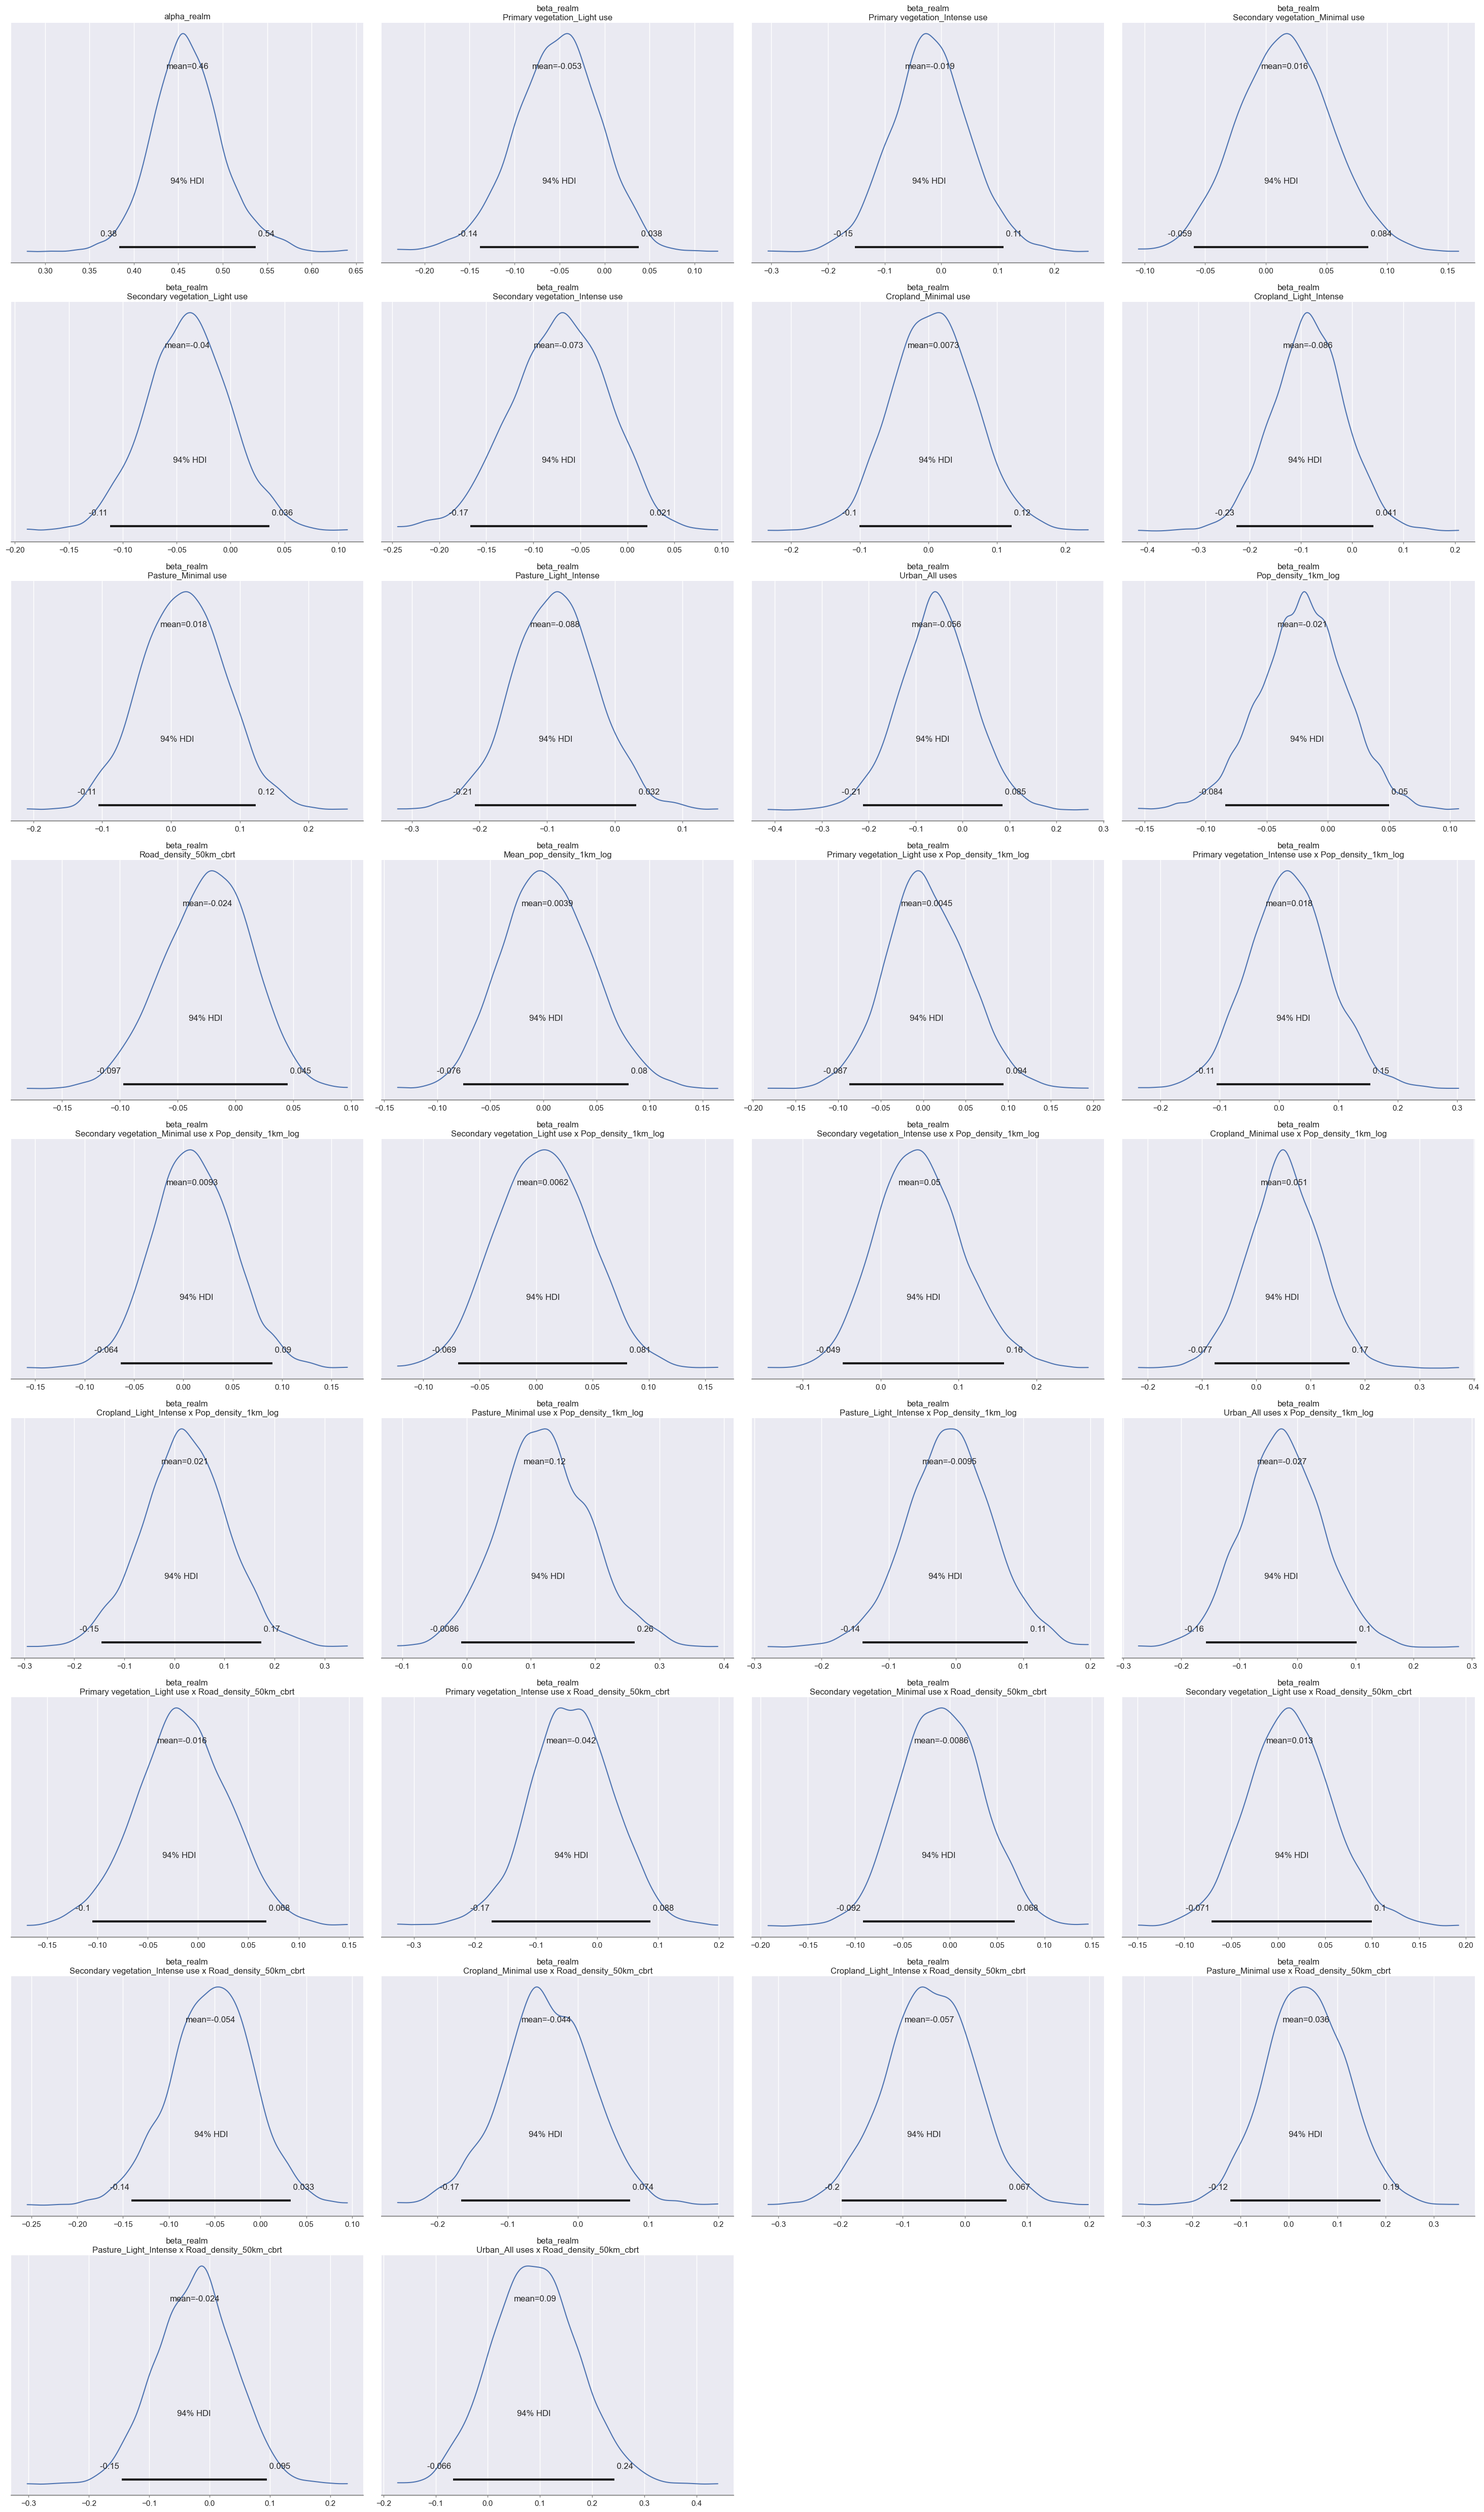

In [1095]:
az.plot_posterior(group_trace, var_names=["alpha_realm", "beta_realm"])
plt.tight_layout();

## Debugging: Model checks

### Prior predictive distribution

In [1169]:
with fitting_model:
    prior_samples = pm.sample_prior_predictive(1000)

Sampling: [biome_offset_1, biome_offset_2, eco_offset_1, eco_offset_2, mu_a, mu_b, realm_offset_1, realm_offset_2, sigma_a, sigma_a_eco, sigma_a_realm, sigma_b, sigma_b_eco, sigma_b_realm, sigma_y, y_like]
INFO:pymc.sampling.forward:Sampling: [biome_offset_1, biome_offset_2, eco_offset_1, eco_offset_2, mu_a, mu_b, realm_offset_1, realm_offset_2, sigma_a, sigma_a_eco, sigma_a_realm, sigma_b, sigma_b_eco, sigma_b_realm, sigma_y, y_like]


In [1097]:
prior_samples

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

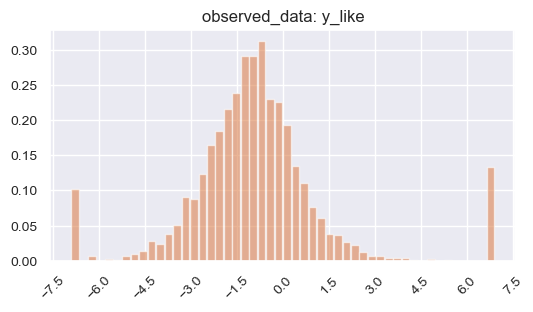

In [1170]:
plot_prior_distribution(prior_samples, category="observed_data", variable="y_like")

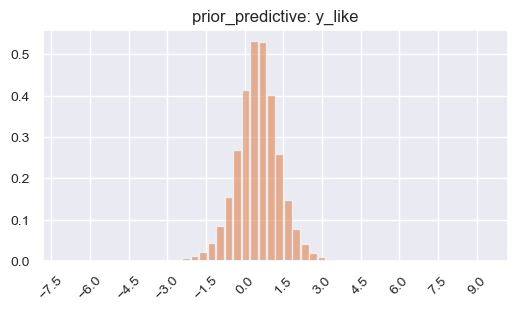

In [1171]:
plot_prior_distribution(prior_samples, category="prior_predictive", variable="y_like")

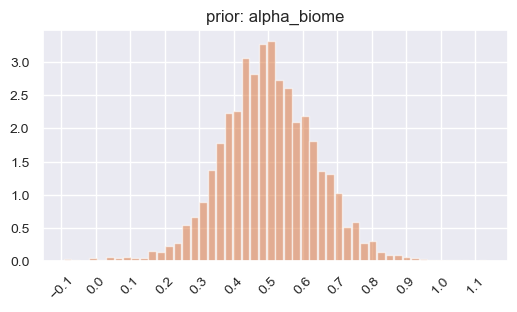

In [1100]:
plot_prior_distribution(prior_samples, category="prior", variable="alpha_biome")

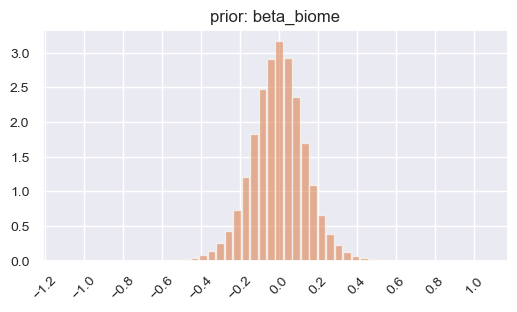

In [1101]:
plot_prior_distribution(prior_samples, category="prior", variable="beta_biome")

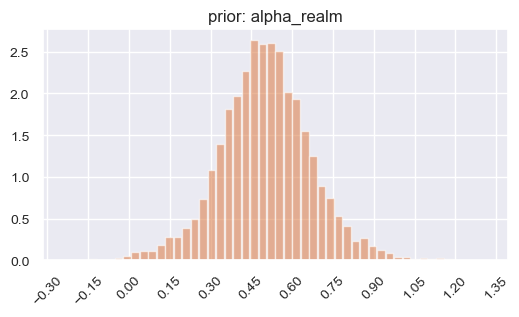

In [1102]:
plot_prior_distribution(prior_samples, category="prior", variable="alpha_realm")

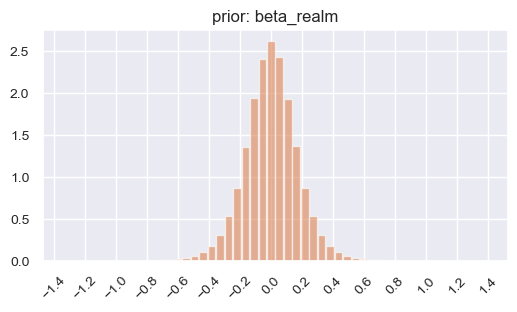

In [1103]:
plot_prior_distribution(prior_samples, category="prior", variable="beta_realm")

### Pairwise correlation of parameters

In [1104]:
# Population level analysis
variables = list(trace.posterior.coords["x_vars"].values)
correlations = []

for var_1, var_2 in itertools.combinations(variables, 2):
    # Extract data for var_1 and var_2
    var_1_data = trace.posterior["mu_b"].sel(x_vars=var_1).values
    var_2_data = trace.posterior["mu_b"].sel(x_vars=var_2).values

    # Calculate the Pearson correlation
    corr = pearsonr(var_1_data.flatten(), var_2_data.flatten())
    correlations.append(corr[0])

# Compute correlations with the intercept
for var in variables:
    index = trace.posterior.coords["x_vars"].values.tolist().index(var)
    var_data = trace.posterior["mu_b"].sel(x_vars=var).values
    intercept_data = trace.posterior["mu_a"].values
    corr = pearsonr(var_data.flatten(), intercept_data.flatten())
    correlations.append(corr[0])

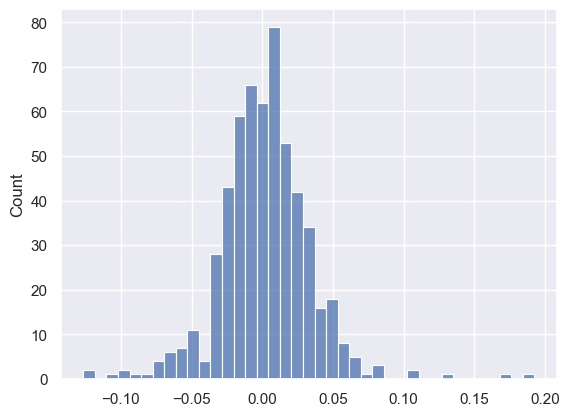

In [1105]:
sns.histplot(correlations);

In [1106]:
# Average correlation per biome-realm
variables = list(trace.posterior.coords["x_vars"].values)
correlations = []
num_groups = len(trace.posterior.coords["alpha_realm_dim_0"].values)
group_corr = {
    f"{var1}-{var2}": []
    for var1, var2 in itertools.combinations(variables + ["intercept"], 2)
}

for group in trace.posterior.coords["alpha_realm_dim_0"].values:
    # Compute correlations within each group
    for var_1, var_2 in itertools.combinations(variables, 2):
        var_1_data = (
            trace.posterior["beta_realm"]
            .sel(beta_realm_dim_0=group, beta_realm_dim_1=var_1)
            .values
        )
        var_2_data = (
            trace.posterior["beta_realm"]
            .sel(beta_realm_dim_0=group, beta_realm_dim_1=var_2)
            .values
        )

        corr = pearsonr(var_1_data.flatten(), var_2_data.flatten())[0]
        group_corr[f"{var_1}-{var_2}"].append(corr)

    # Compute correlations of each variable with the intercept (alpha_biome)
    for var in variables:
        var_data = (
            trace.posterior["beta_realm"]
            .sel(beta_realm_dim_0=group, beta_realm_dim_1=var_1)
            .values
        )
        intercept_data = (
            trace.posterior["alpha_realm"].sel(alpha_realm_dim_0=group).values
        )
        corr = pearsonr(var_data.flatten(), intercept_data.flatten())[0]
        group_corr[f"{var}-intercept"].append(corr)

# Average the correlations across groups
average_corr = {pair: np.mean(corrs) for pair, corrs in group_corr.items()}

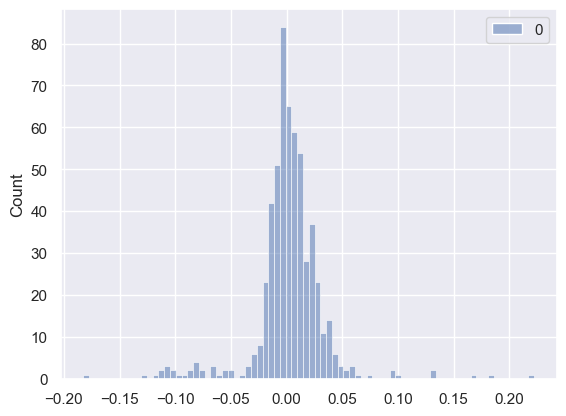

In [1107]:
sns.histplot(average_corr.values());

### Variance per group

In [1108]:
group_idx = model_data["biome_realm_idx"]
groups = np.unique(group_idx)
group_mapping = realm_mapping
for idx, group in enumerate(groups):
    # Select the data for the current group
    mask = group_idx == group
    y_true_group = y_true[mask]
    group_var = np.var(y_true_group)
    print(f"{group_mapping.get(group, group)}: {group_var:.3f}")

Tropical & Subtropical Moist Broadleaf Forests_Oceania: 0.004
Tropical & Subtropical Coniferous Forests_Indo-Malay: 0.004
Tropical & Subtropical Coniferous Forests_Neotropic: 0.003
Tropical & Subtropical Moist Broadleaf Forests_Australasia: 0.004
Tropical & Subtropical Moist Broadleaf Forests_Indo-Malay: 0.002
Tropical & Subtropical Dry Broadleaf Forests_Indo-Malay: 0.004
Tropical & Subtropical Coniferous Forests_Nearctic: 0.003
Tropical & Subtropical Dry Broadleaf Forests_Afrotropic: 0.000
Tropical & Subtropical Moist Broadleaf Forests_Afrotropic: 0.003
Tropical & Subtropical Moist Broadleaf Forests_Neotropic: 0.004
Tropical & Subtropical Dry Broadleaf Forests_Neotropic: 0.003


## Debugging: Sampling statistics

### Trace plots

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (30) is smaller than the number of variables to plot (33), generating only 30 plots
  warnings.warn(


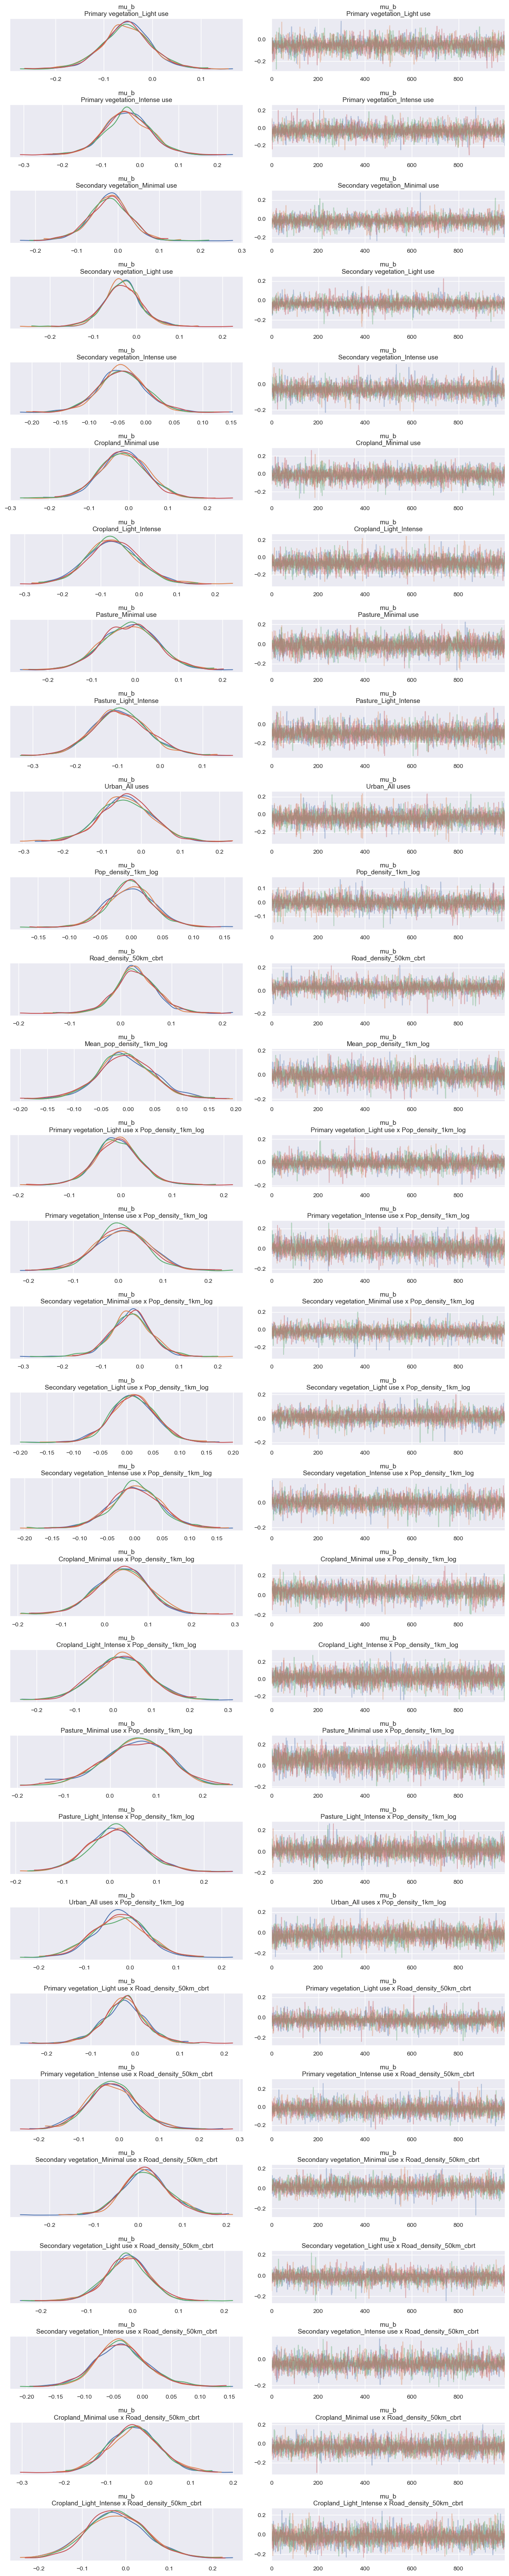

In [1109]:
# Posteriors of hyperpriors: mu_beta
trace_plot(trace, var_names=["mu_b"])

### ESS plots

In [1110]:
# ESS for posterior of hyperparameters
az.plot_ess(trace, kind="evolution", var_names=["beta"])
plt.tight_layout()
plt.show()

KeyError: 'var names: "[\'beta\'] are not present" in dataset'

### Energy plot

In [ ]:
az.plot_energy(trace)
plt.show()

## Detailed debugging

### Autocorrelation in chains

In [ ]:
az.plot_autocorr(trace, var_names=["beta"])
plt.tight_layout();